# Практическая работа по распознаванию речи #4: <br> Поиск наилучшей гипотезы распознавания
Задача распознавания речи состоит в поиске наиболее вероятной словной гипотезы по имеющемуся звуковому сигналу. Используя теорему Байеса, формулировку задачи можно написать так:
$$ W^* = \underset{W}{argmax} {P(W|O)} =  \underset{W}{argmax} \sum_i^N{(\log{P(O|w_i)} + \log{P(w_i|w_{i-1}, w_{i-2},..))}}$$
Где: 
* $O$ - звук
* $W$ - словная гипотеза распознавания 
* $W^*$ - лучшая гипотеза распознавания
* $P(W|O)$ - вероятность гипотезы распознавания при условии наблюдения $O$
* $N$ - количество слов в гипотезе
* $w_i$ - i'ое слово в гипотезе
* $P(O|w_i)$ - акустическое правдоподобие слова (выводится из предсказания акустической моделью)
* $P(w_i|w_{i-1}, w_{i-2},..)$ - языковая вероятность слова при условии контекста (предсказывается языковой моделью)


В прошлых лабораторных работах были изучены акустическая и языковая модели. Акустическая модель предсказывает вероятность принадлежности кадра некоему акустическому классу (фонеме). Языковая модель предсказывает априорную вероятность последовательности слов. Пришло время разобраться, как соединить эти части в одну систему и получить итоговый результат распознавания. 





### Основная часть (14 баллов) данной практической работы состоит из двух частей: 
* знакомство с Weighted Finite State Transducer (WFST)
* WFST декодинг в ASR системе

### Дополнительная часть 
* тюнинг параметров beam search (2 балла)

## Полезные ссылки: 
* Наиболее популярная библиотека WFST - [OpenFst](https://www.openfst.org/twiki/bin/view/FST/WebHome)
* Библиотека для визуализации - [graphviz](https://graphviz.readthedocs.io/en/stable/manual.html)
* Алгоритм обхода графа в ширину - [BFS](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D0%B1%D1%85%D0%BE%D0%B4_%D0%B2_%D1%88%D0%B8%D1%80%D0%B8%D0%BD%D1%83)

In [1]:
!python --version 

Python 3.12.3


In [2]:
#!pip install graphviz kenlm kaldiio jiwer

In [3]:
import numpy as np
import time
import os
import abc

from typing import List, Dict, Union, Set, Any, Optional, Tuple
from tqdm.auto import tqdm
from collections import defaultdict
from pathlib import Path
from dataclasses import dataclass

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import graphviz
import kenlm 
import jiwer
from kaldiio import ReadHelper

/home/artyom/itmo/itmo_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Weighted Finite State Transducer (WFST)



Из определения в wiki [Weighted Finite State Transducer (Взвешенный конечный автомат с выходом)](https://en.wikipedia.org/wiki/Finite-state_transducer) следует, что главная задача FST - это переводить символы из входного алфавита в соответствующие им символы из выходного алфавита. Например, с помощью FST можно перевести последовательность фонем в последовательность слов. Конечный автомат будет менять свое состояние при обработке последовательности входных символов (фонем). Когда он соберет из входных фонем корректную транскрипцию слова, то выдаст это слово на выход. 

Однако не всегда можно однозначно перевести последовательность фонем в слова (некоторые слова произносятся одинаково, а пишутся по-разному), поэтому для распознавания речи надо использовать не простой FST, а взвешенный. WFST позволяет не только перевести входные символы в выходные, но и оценить вес такого перевода. Чем больше вес, тем хуже гипотеза.  

Напишем собственную реализацию WFST.


### AbstractWFST
AbstractWFST -- это базовый интерфейс нашего WFST. В нем заданы основные методы, через которые мы будем работать с wfst  
* get_start - возвращаяет стартовое состояние конечного автомата.
* final_score - вес завершения работы в данном состоянии. В некоторых состояниях завершить обработку невозможно, в таких случаях final weight  будет равен бесконечности.
*  transduce - совершает переход из текущего состояния в следующее, соответствующее переходу по символу ilabel. Возвращает выходной символ, вес перехода и следующее состояние.  




 

In [4]:
class AbstractWFST(abc.ABC):
    def __init__(self):
        pass
    
    @abc.abstractmethod
    def get_start(self) -> Any:
        """Return start state"""
    
    @abc.abstractmethod
    def final_score(self, state: Any) -> float:
        """is the state final? If true return negative log likelihood of the finalization. otherwise return inf"""
           
    @abc.abstractmethod
    def transduce(self, state: Any, ilabel: str) -> Tuple[Tuple[str, float, Any]]:
        """Transduce ilabel to olabel. 
        return all available olabels for this state and ilabel pair
        return type - ((olabel1, weight1, nextstate1), 
                       ((olabel1, weight1, nextstate1), 
                       ...)"""

### SymbolsMap

Для того, чтобы задать WFST, первым делом нам понадобятся таблицы входных и выходных символов. Для задания таблиц будем использовать класс SymbolsMap. Данный класс служит для маппинга символов на индексы и обратно. 

In [5]:
class SymbolsMap:
    def __init__(self, id2symbol: Optional[Dict[int, str]] = None, symbol2id: Optional[Dict[str, int]] = None):
        assert id2symbol is not None or symbol2id is not None, f"One id2symbol or symbol2id must be not None"
        assert id2symbol is None or symbol2id is None, f"Only one One id2symbol or symbol2id can be not None"
        if id2symbol is None:
            self.id2symbol = {i:s for s,i in symbol2id.items()}
        elif isinstance(id2symbol, dict):
            self.id2symbol = id2symbol
        elif isinstance(id2symbol, list):
            self.id2symbol = {i:s for i, s in enumerate(id2symbol)}
        else:
            raise RuntimeError(f"unknown type {type(id2symbol)=}")
            
        if symbol2id is None:
            self.symbol2id = {s:i for i, s in self.id2symbol.items()}
        else:
            self.symbol2id = symbol2id   
                
        assert self.id2symbol[0] == '<eps>', f"wrong {self.id2symbol}"

    def get_id(self, symbol: str):
        return self.symbol2id[symbol]
        
    def get_symbol(self, id: int):
        return self.id2symbol[id] 
    
    @classmethod
    def from_file(cls, fname):
        """read symbols table from file
        format: 
            word id
            word2 id2
            ...
        """
        with open(fname) as f:
            s2i = {s:int(i) for s, i in map(str.split, f.readlines())}
        return cls(symbol2id=s2i)

### Arc и ILabelIndexedArcs
Переходы внутри FST будем описывать с помощью класса, инкапсулирующего информацию о входном/выходном индексе символа, весе перехода и следующем состоянии FST. Поскольку дуги мы будем хранить отдельно для каждого состояния, информация о текущем состоянии в дуге не нужна. 

Для быстрого выбора нужной дуги создадим специальную коллекцию ILabelIndexedArcs. Данная коллекция хранит дуги таким образом, чтобы выбор дуги по входному символу осуществлялся за O(1). 


In [6]:
@dataclass
class Arc:
    """Arc in WFST"""
    ilabel: int
    olabel: int
    weight: float
    nextstate: Any

class ILabelIndexedArcs:
    def __init__(self, arcs: Optional[List[Arc]] = None):
        self.ilabel2arclist = defaultdict(list)
        if arcs is not None:
            for arc in arcs:
                self.add_arc(arc)

    def add_arc(self, arc: Arc):
        self.ilabel2arclist[arc.ilabel].append(arc)

    def get_arcs_by_ilabel(self, ilabel: int):
        return self.ilabel2arclist[ilabel]

    def arcs(self) -> List[Arc]:
        """Return all arcs"""
        all_arcs = []
        # TODO
        # реализуйте функцию, которая возвращает все дуги, хранящиеся в данной коллекции
        #raise NotImplementedError()
        # !!!!!!!!!!!!
        for arclist in self.ilabel2arclist.values():
            all_arcs.extend(arclist)
        return all_arcs 

    def __str__(self):
        return "ILabelIndexedArcs([" + ", ".join(f"{a}" for a in self.arcs()) + "])"
        
    def __repr__(self):
        return str(self)

In [7]:
# test 1.a
def test_ILabelIndexedArcs():
    # проверка что arcs работает правильно 
    arcs = [Arc(i, -i, i/100, i+100) for i in range(10)]
    c = ILabelIndexedArcs(arcs)
    arcs2 = c.arcs()
    
    assert len(arcs) == len(arcs2), f"{len(arcs)=}, {len(arcs2)=}\n{arcs} != {c.arcs()}"
    for a in arcs2:
        assert a in arcs, f"{a=} not in {arcs=}"
    print('Test 1.a passed')
test_ILabelIndexedArcs()    

Test 1.a passed


### WFST 
Все готово для создания взвешенного конечного автомата. Класс WFST состоит из таблицы входных и выходных символов, списка состояний и коллекции дуг для каждого, а также множества финальных состояний. 

In [8]:
class WFST(AbstractWFST):
    def __init__(self, 
                 isymbols: Optional[SymbolsMap] = None, 
                 osymbols: Optional[SymbolsMap] = None):
        self.start = 0
        self.states = 0
        # состояния, в которых может завершиться декодирование без какого либо штрафа 
        self.final_states = set() 
        self.isymbols = isymbols
        self.osymbols = osymbols
        self.state2arcs = defaultdict(ILabelIndexedArcs)

    def get_start(self):
        """return start state"""
        return self.start
        
    def final_score(self, state_id: int):
        """return the weight of decoding completion in state_id"""
        # TODO 
        # верните вес завершения декодирования в state_id 
        # Если stateid — финальный, возвращаем 0, иначе inf
        if state_id in self.final_states:
            return 0.0
        return float('inf')
       
    def transduce(self, state, ilabel: str) -> Tuple[Tuple[str, float, int]]:
        """transitions wfst to next state by 'ilabel' input symbol, except when the input symbol is <eps>.
        Returns all possible output results as a tuple of triples (olabel, weight, nextstate)."""
        assert self.isymbols is not None and self.osymbols is not None, f"Cannot transduce w/o both symbols tables" 
        if ilabel == '<eps>':
            # skip <eps> input
            return ((ilabel, 0, state), )
        label_id = self.isymbols.get_id(ilabel)
        # TODO 
        # верните все возможные результаты перехода из текущего состояния по входу ilabel
        # результат должен выглядеть так: tuple(("слово", 0.1, 2), ("другоеслово", 10, 4), ...)
        arcs = self.state2arcs[state].get_arcs_by_ilabel(label_id)
        results = []
        for arc in arcs:
            # Преобразуем int обратно в word через osymbols
            results.append((self.osymbols.get_symbol(arc.olabel), arc.weight, arc.nextstate))
        return tuple(results)
    
    def set_final(self, state: int):
        """sets the final weight for the state to zero"""
        # TODO добавьте возможность завершать декодирование в state
        self.final_states.add(state)
        
    def new_state(self):
        """Create new state id and return it"""
        # TODO 
        # добавьте в конечный автомат новое состояние и верните его id 
        self.states += 1
        return self.states
        #return state_id
    
    def add_arc(self, state_from: int, arc: Arc):
        """adds a new arc for this state"""
        # TODO 
        # добавьте в конечный автомат новых переход arc, выходящий из state_from 
        self.state2arcs[state_from].add_arc(arc)
    '''    
    def to_dot(self):
        """Visualize the WFST""" 
        dot = graphviz.Digraph()
        for s in self.states:
            dot.node(str(s))
        for state_from, arcs_container in self.state2arcs.items():
            for arc in arcs_container.arcs():
                il = self.isymbols.get_symbol(arc.ilabel) if self.isymbols is not None else arc.ilabel
                ol = self.osymbols.get_symbol(arc.olabel) if self.osymbols is not None else arc.olabel
                dot.edge(str(state_from), str(arc.nextstate), label=f"{il}:{ol}:{arc.weight:.2f}")
        return dot'''


    def to_dot(self):
    #Visualize the WFST
        dot = graphviz.Digraph()
        
        # Итерируем по всем состояниям, которые есть в state2arcs
        # Плюс добавляем стартовое состояние и финальные
        all_states = set(self.state2arcs.keys())
        all_states.add(self.start)
        all_states.update(self.final_states)
        
        # Рисуем узлы
        for s in all_states:
            if s in self.final_states:
                dot.node(str(s), shape='doublecircle')  # Финальные состояния - двойной круг
            else:
                dot.node(str(s))
        
        # Рисуем дуги
        for state_from, arcs_container in self.state2arcs.items():
            for arc in arcs_container.arcs():
                input_symbol = self.isymbols.get_symbol(arc.ilabel) if self.isymbols else str(arc.ilabel)
                output_symbol = self.osymbols.get_symbol(arc.olabel) if self.osymbols else str(arc.olabel)
                label = f"{input_symbol}:{output_symbol}/{arc.weight:.2f}"
                dot.edge(str(state_from), str(arc.nextstate), label=label)
        
        return dot


In [9]:
# test 1.b
def test_WFST():
    en_l = SymbolsMap(id2symbol=['<eps>', 'b', 'd', 'u'])
    ru_l = SymbolsMap(id2symbol=['<eps>', 'ю', 'б', 'д'])
    
    # create first transducer
    en2ru = WFST(isymbols=en_l, osymbols=ru_l)
    # new_state
    en2ru_final = en2ru.new_state()
    assert en2ru_final == 1 , f'start - zero, next state - one, next - two ...'
    assert en2ru.new_state() == 2, f'start - zero, next state - one, next - two ...'
    en2ru.set_final(en2ru_final)
    en2ru.add_arc(en2ru.get_start(), Arc(1, 2, 1.0, en2ru_final))
    en2ru.add_arc(en2ru_final, Arc(2, 3, 2.0, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(3, 1, 3.0, en2ru_final))
    # you can use this line to visualize
    #display.display(en2ru.to_dot())

    # final_score # set_final
    assert en2ru.final_score(en2ru.get_start()) == float('inf')
    assert en2ru.final_score(en2ru_final) == 0
    en2ru.set_final(en2ru.get_start())
    assert en2ru.final_score(en2ru_final) == en2ru.final_score(en2ru.get_start()) == 0

        
    # transduce # add_arc
    assert en2ru.transduce(en2ru.get_start(), 'd') == tuple() , "Cannot transduce 'd' from start state. output must be zero len tuple"
    assert en2ru.transduce(en2ru.get_start(), 'b') == (('б', 1.0, en2ru_final), ) , "Arc(1, 2, 1.0, en2ru_final)"
    assert en2ru.transduce(en2ru.get_start(), 'u') == (('ю', 3.0, en2ru_final), ) , "Arc(3, 1, 3.0, en2ru_final)"
    assert en2ru.transduce(en2ru_final, 'd') == (('д', 2.0, en2ru.get_start()), ) , "Arc(2, 3, 2.0, en2ru.get_start())"
    
    print('test 1.b passed')
test_WFST()

test 1.b passed


## wfst композиция 


Над WFST определен большой набор различных операций, реализация большинства из которых является сложной алгоритмической задачей. Важной для распознавания речи операцией является [композиция](https://www.openfst.org/twiki/bin/view/FST/ComposeDoc) набора различных wfst. 

OpenFST дает следующее определение композиции:
 
"This operation computes the composition of two transducers. If A transduces string x to y with weight a and B transduces y to z with weight b, then their composition transduces string x to z with weight a ⊗ b."

Другими словами, результатом композиции является wfst, применение которого к входной последовательности даст такой же результат, как и последовательное применение композируемых wfst. 

Хорошим примером композиции различных WFST является граф распознавания в гибридных системах распознавания речи. Такой граф является результатом композиции четырех wfst:
* H - Hidden Markov Model wfst (переводит акустические классы, предсказанные с помощью AM, в трифоны)
* С - Context-dependency transducer (переводит трифоны (тройки (leftcontext,phone,rightcontext)) в фонемы)
* L - lexicon (переводит фонемы в слова)
* G - ngram lm (оценивает вероятность последовательностей слов)
 
Итого граф распознавания можно выразить с помощью следующей формулы:
$$ HCLG = H⊗C⊗L⊗G $$ 
где ⊗ - оператор композиции двух wfst. Подробнее про граф распознавания можно почитать в [документации к фреймворку kaldi](https://kaldi-asr.org/doc/graph.html)


Композиция позволяет объединить много обработчиков в один большой граф, что несомненно является большим плюсом для построения продакшн решений. Но у такого подхода есть и минусы - процесс подготовки графа очень сложен и требует множества оптимизаций. Это усложняет любые эксперименты и модификации системы. В данной работе мы не будем реализовывать честную композицию графа, а будем считать композицию "On the Fly". То есть сделаем обертку, реализующую интерфейс AbstractWFST, состоянием которой будет Tuple состояний всех композируемых wfst, а метод transduce будет последовательно проходить через эти wfst. Тем самым, по определению композиции, наш класс будет эквивалентен честной композиции.  



In [10]:
class OnTheFlyCompose(AbstractWFST):
    def __init__(self, wfsts: List[AbstractWFST]):
        # !!!Attention!!! wfsts - это лист AbstractWFST, а не WFST. 
        # Для работы с wfsts истользуйте только методы из AbstractWFST
        self.wfsts = wfsts

    def get_start(self):
        return tuple(fst.get_start() for fst in self.wfsts)
    '''
    def final_score(self, state: Tuple[Any]):
        assert len(state) == len(self.wfsts)
        # TODO 
        # посчитайте финальный скор для state
        # результат композиции может завершить обработку только в тех стейтах, где все wfsts будут в финальных состояниях
        # Композиция завершена только если ВСЕ wfsts в финальных состояниях
        scores = [fst.final_score(s) for fst, s in zip(self.wfsts, state)]
        if all(score == 0 for score in scores):
            return 0.0
        return float('inf')
    '''
    def final_score(self, state: Tuple[Any]):
        assert len(state) == len(self.wfsts)
        total_score = 0.0
        for fst, s in zip(self.wfsts, state):
            score = fst.final_score(s)
            if score == float('inf'):
                return float('inf')
            total_score += score
        return total_score
    
    def _transduce(self, state: Tuple[Any], ilabel: str) -> List[Tuple[List[str], float, List[int]]]:
        assert len(self.wfsts) == len(state)
        # Найдите все возможные гипотезы перевода ilabel с помощью композиции всех self.wfsts
        # Последовательно пройдите через все self.wfsts, расширяя список гипотез и дополняя гипотезы новыми слоями 
        # Верните результат в виде списка гипотез. 
        # Каждая гипотеза содержит три элемента: 
        #   0. список символов со ВСЕХ прошедших слоев композиции 
        #   1. суммарный вес гипотезы 
        #   2. список состояний, в которые перешли self.wfsts 

        # Одна стартовая гипотеза. Корень для всех гипотез.
        # Еще никакой wfst не применен, символ только ilabel, вес стартовый, стейтов еще нет. 
        hyps_per_layer = [([ilabel], 0, [])]  
        for fst, s in zip(self.wfsts, state):
            new_hyps = []
            # TODO 
            # примените fst.transduce ко всем гипотезам из hyps_per_layer
            # постепенно разветвляя их и сохраняя в new_hyp
            # на вход подайте выход последнего из уже обработаных слоев 
            # Для каждой текущей гипотезы
            for symbols_list, weight, states_list in hyps_per_layer:
                # На вход подаём последний символ из гипотезы (выход предыдущего слоя)
                input_symbol = symbols_list[-1]
                
                # Применяем fst.transduce с текущим состоянием fst
                arcs = fst.transduce(s, input_symbol)
                
                # Расширяем гипотезу для каждого возможного перехода
                for output_symbol, arc_weight, next_state in arcs:
                    new_symbols = symbols_list + [output_symbol]  # Добавляем выходной символ
                    new_weight = weight + arc_weight  # Суммируем веса
                    new_states = states_list + [next_state]  # Добавляем новое состояние
                    
                    new_hyps.append((new_symbols, new_weight, new_states))
            hyps_per_layer = new_hyps
            
        return hyps_per_layer

    def transduce(self, state: Tuple[Any], ilabel: str):
        hyps_per_layer = self._transduce(state, ilabel)
        # выходной символ transduce в композиции - это выходной символ самого последнего wfst 
        return tuple((ls[-1], w, tuple(ss)) for ls, w, ss in hyps_per_layer)
    

In [11]:
def test_OnTheFlyCompose():
    en_l = SymbolsMap(id2symbol=['<eps>', 'b', 'd', 'u'])
    ru_l = SymbolsMap(id2symbol=['<eps>', 'ю', 'д', 'б'])
    en_U = SymbolsMap(id2symbol=['<eps>', 'B', 'D', 'U'])
    ru_U = SymbolsMap(id2symbol=['<eps>', 'Ю', 'Д', 'Б'])
    
    # create first transducer
    en2ru = WFST(isymbols=en_l, osymbols=ru_l)
    en2ru_final = en2ru.new_state()
    en2ru.set_final(en2ru_final)
    en2ru.add_arc(en2ru.get_start(), Arc(1, 3, 1.0, en2ru_final))
    en2ru.add_arc(en2ru_final, Arc(2, 2, 2.0, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(2, 0, 0.1, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(3, 1, 3.0, en2ru_final))
    # you can use this line to visualize
    # display.display(en2ru.to_dot())

    # OnTheFlyCompose одного fst работает так же как и этот fst
    comp = OnTheFlyCompose([en2ru])
    for s in (0, 1):
        for il in 'bdu':
            hyps1 = en2ru.transduce(s, il)
            hyps2 = comp.transduce((s,), il)
            for h in hyps2:
                # only one state
                assert len(h[2]) == 1, f"{hyps2=}"
            hyps2_flatten = tuple((l, w, ss[0]) for l,w,ss in hyps2)
            assert hyps1 == hyps2_flatten, f"{hyps1=} {hyps2_flatten=}"
        
        scores = [float('inf'), 0]
        your_score = comp.final_score((s,))
        assert your_score == scores[s], f"Your score = {your_score}, correct = {scores[s]}"

    # create second transducer
    ru2en = WFST(isymbols=ru_l, osymbols=en_U)
    ru2en_final = ru2en.new_state()
    ru2en.set_final(ru2en_final)
    ru2en.add_arc(ru2en.get_start(), Arc(3, 1, 10.0, ru2en_final))
    ru2en.add_arc(ru2en_final, Arc(2, 2, 20.0, ru2en_final))
    ru2en.add_arc(ru2en_final, Arc(2, 2, 30.0, ru2en.get_start()))
    ru2en.add_arc(ru2en_final, Arc(1, 3, 40.0, ru2en.get_start()))
    
    # you can use this line to visualize
    # display.display(ru2en.to_dot())

    # композиция двух работает как последовательное применение каждого 
    comp = OnTheFlyCompose([en2ru, ru2en])
    hyps = comp.transduce((0, 0), 'b')
    assert hyps == (('B', 11.0, (1, 1)), ) , f"{hyps =}"
    hyps = comp.transduce((1, 1), 'd')
    assert hyps == (('D', 22.0, (0, 1)), ('D', 32.0, (0, 0))) , f"{hyps =}"
    hyps = comp.transduce((0, 1), 'd')
    assert hyps == (('<eps>', 0.1, (0, 1)), ) , f"{hyps =}"
    # Проверка правильности расчетов final_score
    your_score = comp.final_score((0, 0))
    assert your_score == float('inf'), f"Your score = {your_score}, correct = {float('inf')}"
    your_score = comp.final_score((0, 1))
    assert your_score == float('inf'), f"Your score = {your_score}, correct = {float('inf')}"
    your_score = comp.final_score((1, 0))
    assert your_score == float('inf'), f"Your score = {your_score}, correct = {float('inf')}"
    your_score = comp.final_score((1, 1))
    assert your_score == 0, f"Your score = {your_score}, correct = {0}"
    print('Test 1.c passed')
    
    
test_OnTheFlyCompose()

Test 1.c passed


# 2. WFST декодинг в ASR системе
Отлично, код WFST готов, теперь необходимо собрать граф распознавания и написать поиск наилучшей гипотезы 




In [12]:
# Сначала подготовим нужные нам таблицы символов
AM_PHONES = {0: 'pau', 1: 'aa', 2: 'ae', 3: 'ah', 4: 'ao', 5: 'aw', 6: 'ax', 7: 'ax-h', 8: 'axr', 9: 'ay', 10: 'b', 
             11: 'bcl', 12: 'ch', 13: 'd', 14: 'dcl', 15: 'dh', 16: 'dx', 17: 'eh', 18: 'el', 19: 'em', 20: 'en', 
             21: 'eng', 22: 'er', 23: 'ey', 24: 'f', 25: 'g', 26: 'gcl', 27: 'hh', 28: 'hv', 29: 'ih', 30: 'ix', 
             31: 'iy', 32: 'jh', 33: 'k', 34: 'kcl', 35: 'l', 36: 'm', 37: 'n', 38: 'ng', 39: 'nx', 40: 'ow', 
             41: 'oy', 42: 'p', 43: 'pcl', 44: 'q', 45: 'r', 46: 's', 47: 'sh', 48: 't', 49: 'tcl', 50: 'th', 
             51: 'uh', 52: 'uw', 53: 'ux', 54: 'v', 55: 'w', 56: 'y', 57: 'z', 58: 'zh'}

# таблица фонем для wfst 
def create_phones_txt(fname='exp/phones.txt'):
    fname = Path(fname) 
    fname.parent.mkdir(exist_ok=True, parents=True)
    with open(fname, 'w') as f:
        f.write('<eps> 0\n') # !! shift all ids by one !! 
        for i, p in sorted(AM_PHONES.items()):
            f.write(f'{p} {i+1}\n')
create_phones_txt()


In [13]:
# Загрузим подготовленный лексикон из датасета 
def load_lexicon_file(fname='timit/TIMITDIC.TXT', words_limit=-1):
    """generator running through the 'fname' phonetic dictionary 
    yield (word: str, phones: List[str])"""
    num = 0
    with open(fname) as f:
        for line in map(str.strip, f.readlines()):
            if line.startswith(';'):
                continue
            word, trans, _ = line.split('/')
            # remove ~adj suffix 
            word = word.split('~')[0].strip() 
            # remove stress factor
            trans = [t[:-1] if t[-1].isdigit() else t for t in trans.split()]
            yield word, trans
            num += 1
            if words_limit == num:
                break

In [14]:
# подготовим таблицу слов
def create_words_txt(fname='exp/words.txt', dic_fname='timit/TIMITDIC.TXT'):
    fname = Path(fname)
    fname.parent.mkdir(exist_ok=True, parents=True)
    words = ['<eps>'] + [w for w, _ in sorted(load_lexicon_file(dic_fname))] + ['<s>', '</s>']
    with open(fname, 'w') as f:
        f.write(''.join(f'{w} {i}\n' for i, w in enumerate(words)))
create_words_txt()

# T transducer

Создадим первый wfst. 

В гибридном пайплайне системы распознавания речи задача первых двух wfst (H и C) - это перевести предсказанные с помощью акустической модели классы в последовательность фонем. В нашем случае все значительно легче, так как АМ (из работы №3) уже учится предсказывать фонемы, поэтому мы не будем использовать HС трансдьюсеры. 

В этой работе будет использоваться простой трасдьюсер T. Этот wfst нужен для преобразования вероятностей фонем, которые оценивает AM, в их правдоподобие. Используя теорему Баеса, сделать это преобразование легко. Надо просто добавить к скорам фонем их априорную вероятность.


T.wfst состоит из одного состояния и N петель, где N - это количество фонем. Каждая петля соответствует определенной фонеме и хранит логарифм ее априорной вероятности.

![image](resources/lab4/H_example.svg)

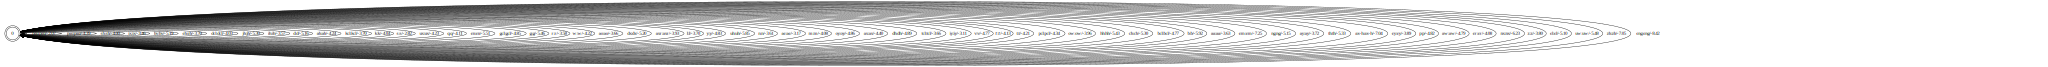

In [15]:
def create_t_wfst(prior_file='resources/lab4/phone.priors', phones_fname='exp/phones.txt'):
    """Create T.wfst. just transduce AM probability to AM likelihood (Bayes theorem)
    """
    symbols = SymbolsMap.from_file(phones_fname)
    t_fst = WFST(isymbols=symbols, osymbols=symbols)
    s = t_fst.get_start()
    t_fst.set_final(s)
    with open(prior_file) as f:
        for ph, prior in map(str.split, f.readlines()):
            log_prior = np.log(float(prior))
            ph_id = symbols.get_id(ph)
            t_fst.add_arc(s, Arc(ph_id, ph_id, log_prior, s))
    return t_fst
create_t_wfst().to_dot()

# L transducer

Lwfst - это WFST, который преобразует входные последовательности фонем в слова.

Например, `pau pau ae1 ae1 ae1 ae1 ae1 ae1 r pau pau pau y y y y eh1 s s s pau` -> `air yes`

Чтобы контролировать количество слов в выходной гипотезе, в L добавляется два веса: 
* word_insertion_penalty - штраф за добавление слова 
* stay_in_silence_penalty - штраф за пропуск паузы (фонемы pau)

Пример Lwfst, построенного для слов `'em` `-knacks`, с параметрами word_insertion_penalty=0.5, stay_in_silence_penalty=0.01

![image](./resources/lab4/L_example.svg)

Фонема паузы pau обрабатывается особым способом: L.fst может пропускать ее, не генерируя ничего на выходе. Также у окончания каждой транскрипции слова есть две отдельные дуги, возвращающие FST в стартовое состояние. Это нужно для того, чтобы была возможность как обработать подряд идущие дупликаты последней фонемы на конце слова, так и перейти в стартовое состояние всего по одной финальной фонеме. 

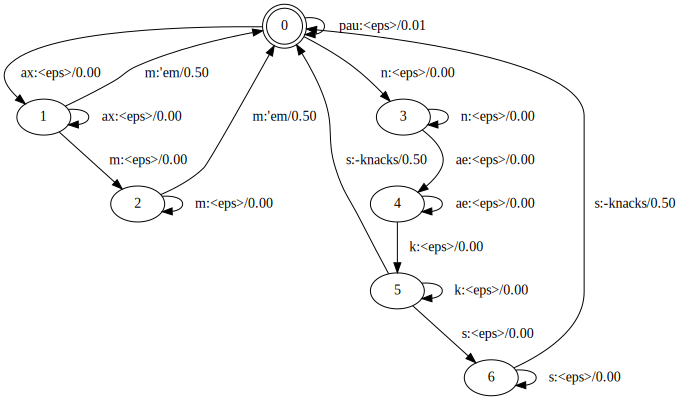

In [16]:
def create_Lwfst_from_file(dic_fname='timit/TIMITDIC.TXT', 
                           phones_fname='exp/phones.txt', 
                           words_fname='exp/words.txt', 
                           words_limit=-1,
                           word_insertion_penalty=0.5, 
                           stay_in_silence_penalty=0.01):
    isymbols = SymbolsMap.from_file(phones_fname)
    osymbols = SymbolsMap.from_file(words_fname)
    sil_id = isymbols.get_id('pau')
    l_wfst = WFST(isymbols=isymbols, osymbols=osymbols)
    start = l_wfst.get_start()
    ### Пропуск скольких угодно фонем тишины
    l_wfst.add_arc(start, Arc(sil_id, 0, stay_in_silence_penalty, start))
    # Стартовое состояние также является и финальным
    l_wfst.set_final(start)
    
    for word, trans in load_lexicon_file(dic_fname, words_limit=words_limit):
        try:
            tran_ids = [isymbols.get_id(t) for t in trans]
            word_id = osymbols.get_id(word)
        except:
            continue

        # Проверяем, что всё корректно получилось
        if any(tid is None or tid == 0 for tid in tran_ids) or word_id is None or word_id == 0:
            continue
        # TODO 
        # Добавьте последовательные дуги в wfst, определяющие транскрипцию слова
        # Все дуги, кроме последней, на выходе имеют <eps>
        # Последняя дуга выводит word_id и возвращает конечный автомат в стартовое (оно же финальное) состояние
        # Каждая фонема может тянуться от 1 до inf кадров, поэтому помимо переходов в новое состояние, должны быть еще петли 
        prev_state = start
    
        # Для каждой фонемы в слове
        for i, phone_id in enumerate(tran_ids[:-1]):
            # Создаём новое состояние для этой фонемы
            state = l_wfst.new_state()
            
            # Переход из предыдущего состояния в новое с этой фонемой
            # На выходе пока <eps> (id=0)
            l_wfst.add_arc(prev_state, Arc(phone_id, 0, 0.0, state))
            
            # Петля — фонема может повторяться (тянуться)
            l_wfst.add_arc(state, Arc(phone_id, 0, 0.0, state))
            
            prev_state = state
        
        # Обрабатываем последнюю фонему особым образом
        last_phone_id = tran_ids[-1]
        final_state = l_wfst.new_state()
        
        # Обычный переход для последней фонемы
        l_wfst.add_arc(prev_state, Arc(last_phone_id, 0, 0.0, final_state))
        
        # Петля для последней фонемы
        l_wfst.add_arc(final_state, Arc(last_phone_id, 0, 0.0, final_state))
        
        # Переход ВЫДАЮЩИЙ СЛОВО по последней фонеме
        l_wfst.add_arc(prev_state, Arc(last_phone_id, word_id, word_insertion_penalty, start))
        
        # Также переход по последней фонеме в финальное состояние (для продолжения)
        l_wfst.add_arc(final_state, Arc(last_phone_id, word_id, word_insertion_penalty, start))
        
    return l_wfst

create_Lwfst_from_file(words_limit=2, word_insertion_penalty=0.5, stay_in_silence_penalty=0.01).to_dot()

In [17]:
def test_l_wfst():
    l_wfst = create_Lwfst_from_file(dic_fname='timit/TIMITDIC.TXT', 
                                    word_insertion_penalty=1.0, stay_in_silence_penalty=0.01)
    start = l_wfst.get_start()
    hyps = l_wfst.transduce(start, 'pau')
    loop_hyp = [(l, w, s) for l, w, s in hyps if s == start]
    assert (len(loop_hyp) == 1 
            and loop_hyp[0][0] == '<eps>' 
            and loop_hyp[0][1] == 0.01), f"{hyps}\n skip pause test failed"
    # смотрим, что поданная на вход транскрипция корректно переводится в слово
    # количество подряд идущих одинаковых фонем постепенно увеличивается от одной до 6
    for i, (word, trans) in enumerate(tqdm(load_lexicon_file('timit/TIMITDIC.TXT', words_limit=100), total=100)):
        hyps = [('', 0, l_wfst.get_start()), ]
        # Breadth First Search
        for t in [t for t in trans for _ in range(i//20+1)]:
            # t repeated many times
            new_hyps = []
            for prev_l, prev_w, prev_s in hyps: 
                new_hyps.extend([(f"{prev_l} {l}", prev_w + w, s) for l,w,s in l_wfst.transduce(prev_s, t)])
            hyps = new_hyps
        # choose only final hyp
        # ограничение веса нужно, чтобы отсечь гипотезы где комбинация других слов мапится на теже фонемы
        hyps = [(l, w, s) for l, w, s in hyps if l_wfst.final_score(s) != float('inf') and w == 1.0]
       
        assert len(hyps) == 1 or len(trans) == 1 , f"Test failed for word \"{word}\" {hyps=}"
        assert hyps[0][0].replace('<eps>', ' ').split() == [word], f"Test failed for word {word} {hyps=}"
        assert hyps[0][1] == 1.0, f"Test failed for word {word} {hyps=}"
        assert hyps[0][2] == start, f"Test failed for word {word} {hyps=}"       
    print("test 2.a passed")
test_l_wfst()

100%|██████████| 100/100 [00:01<00:00, 72.53it/s]

test 2.a passed


# Поиск наилучшей гипотезы распознавания с помощью beam search

Для того, чтобы найти результат распознавания с помощью акустической модели и графа распознавания, надо выполнить поиск наилучшей гипотезы в графе. Для поиска лучшего пути будем использовать [лучевой поиск (Beam Search)](https://ru.wikipedia.org/wiki/%D0%9B%D1%83%D1%87%D0%B5%D0%B2%D0%BE%D0%B9_%D0%BF%D0%BE%D0%B8%D1%81%D0%BA). В основе этого алгоритма лежит обход графа в ширину, но на каждом шаге рассматриваются только наиболее "хорошие" гипотезы, а остальные уничтожаются. Такая эвристика позволяет значительно ускорить процесс декодирования, но не всегда находит наилучший путь. 

In [18]:
@dataclass(order=True)
class Hypothesis:
    # накопленный штраф гипотезы
    score: float
    # до какого кадра из входной последовательности дошла гипотеза
    time: int
    # накопленная последовательность слов
    words: List[str]
    # состояние графа декодирования 
    state: Any


### HypothesesKeeper
Реализуем специальную коллекцию, которая хранит все гипотезы распознавания и применяет прунинг (удаление ненужных гипотез). 
Прунинг делится на два типа: 
#### State pruning 
Eсли мы можем дойти до состояния X в момент времени T несколькими способами, то для дальнейшей обработки достаточно только наилучшего пути до состояния X. Эта гипотеза гарантированно будет лучше всех других гипотез, проходящих через точку (X, T). 
#### Beam pruning
Эвристика лучевого поиска. Отсекаем все гипотезы, которые хуже, чем лучшая текущая гипотеза плюс beam_size. Вероятность того, что гипотезы с сильно худшим весом вдруг станут наилучшими, крайне мала, поэтому такая эвристика работает достаточно хорошо. 


In [19]:
class HypothesesKeeper:
    def __init__(self, init_hyps: List[Hypothesis] = [], beam_size=10):
        self.state2hyp = {h.state: h for h in init_hyps}
        self.beam_size = beam_size
        if len(self.state2hyp) == 0:
            self.set_best(None, float('inf'))
        else:
            min_hyp = min(self.state2hyp.values())
            self.set_best(min_hyp.state, min_hyp.score)

    def set_best(self, state, score):
        self.best_state = state
        self.best_score = score
        
    def get_best_hyp(self) -> Hypothesis:
        """return the best hyp based on self.best_state"""   
        # TODO 
        # верните лучшую гипотезу 
        if self.best_state is None:
            return None
        return self.state2hyp.get(self.best_state, None)
    
    def prune(self):
        self.state2hyp = {s:h for s, h in self.state2hyp.items() if not self.is_prunned_by_beam(h.score)}
        
    def tolist(self) -> List[Hypothesis]:
        """Return all hypotheses. Apply beam pruning"""
        # TODO 
        # верните все гипотезы, которые находятся в луче поиска 
        return [h for h in self.state2hyp.values() if not self.is_prunned_by_beam(h.score)]
    
    def is_prunned_by_beam(self, score: float):
        """Return true if score greater than beam"""
        # TODO 
        # верните True, если значение score находится вне луча поиска 
        return score > self.best_score + self.beam_size
        
    def is_prunned_by_state(self, state, score):
        """Returns true if the keeper already has a hyp in the same state and the score of this hyp is lower"""
        # TODO
        # верните True, если state уже имеет гипотезу, со скором лучше чем score
        existing_hyp = self.state2hyp.get(state)
        return existing_hyp is not None and existing_hyp.score <= score
    
    def append(self, hyp: Hypothesis):
        """Append new hyp into collection"""
        if self.is_prunned_by_beam(hyp.score) or self.is_prunned_by_state(hyp.state, hyp.score):
            return 
        self.state2hyp[hyp.state] = hyp
        if hyp.score < self.best_score or self.best_state is None:
            self.set_best(hyp.state, hyp.score)

    def extend(self, hyps):
        if isinstance(hyps, HypothesesKeeper):
            hyps = hyps.tolist()
        for h in hyps:
            self.append(h)
    
    def __len__(self):
        return len(self.state2hyp)

    def __str__(self):
        return '[' + ",\n".join(map(str, self.tolist())) + ']'

    def describe(self):
        # TODO 
        # посчитайте средний и максимальный скор хранящихся гипотез
        # mean_score = ...
        # max_score = ...
        if len(self.state2hyp) == 0:
            mean_score = float('inf')
            max_score = float('inf')
        else:
            scores = [h.score for h in self.state2hyp.values()]
            mean_score = sum(scores) / len(scores)
            max_score = max(scores)
        return (
            f"{len(self)} hyps. "
            f"Best {self.get_best_hyp()}. "
            f"Mean score {mean_score:.2f}. "
            f"Max {max_score:.2f}"
        )

In [20]:
def test_hyp_keeper():
    hyps = HypothesesKeeper(beam_size=10)
    hyps.append(Hypothesis(10, 0, ['a'],  1))
    assert len(hyps) == 1 and hyps.best_state == 1 and hyps.best_score == 10, f"First append doesn't work well"
    hyps.append(Hypothesis(100, 0, ['err'], 2))
    assert len(hyps) == 1 and hyps.best_state == 1 and hyps.best_score == 10, f"Append didn't prune the input"
    
    hyps.append(Hypothesis(11, 0, ['b'], 2))
    assert len(hyps) == 2 and hyps.best_state == 1 and hyps.best_score == 10, f"Append doesn't work well"
    hyps.append(Hypothesis(12, 0, ['err2'], 2))
    assert len(hyps) == 2 and hyps.state2hyp[2].score == 11, f"Append didn't prune the input"
    
    hyps.append(Hypothesis(0, 0, ['c'], 3))
    assert hyps.best_state == 3 and hyps.best_score == 0, f"Append didn't update best_* attributes"

    hyps_list = hyps.tolist()
    assert len(hyps_list) == 2, f"tolist didn't prune the output"

    hyp = hyps.get_best_hyp()
    assert hyp == Hypothesis(0, 0, ['c'], 3), f"{hyp=}"
    print("test 2.b passed!")
test_hyp_keeper()

test 2.b passed!


In [21]:
class BeamSearcher:
    def __init__(self, am2phone_mapping, graph: AbstractWFST, beam_size=3):
        self.am2phone_mapping = am2phone_mapping
        self.graph = graph
        self.beam_size = beam_size
        
    def decode(self, phonemes_nll: np.ndarray):
        """
        Decoding input phonemes negative loglikelihood into word level hypthesis
        phonemes_logprobs.shape is (Time, num_phones)
        """
        parent_hyps = HypothesesKeeper(init_hyps=[Hypothesis(0, -1, [], self.graph.get_start())], 
                                       beam_size=self.beam_size)
        pbar = tqdm(phonemes_nll)
        for new_time, frame_dist in enumerate(pbar):
            new_hyps = HypothesesKeeper(beam_size=self.beam_size)
            # print(parent_hyps)
            for parent_hyp in parent_hyps.tolist():
                assert parent_hyp.time + 1 == new_time, f"Wrong time {new_time=}, \n{parent_hyp=}"
                # TODO 
                # Продолжите гипотезу parent_hyp с помощью всех фонем и их вероятностей из frame_dist
                # соханите новые гипотезы в new_hyps
                # words гипотез не должен содержать <eps> 
                # score гипотезы равен сумме скора родителя, phone_nll и веса от transduce по графу
                for phone_id, phone_nll in enumerate(frame_dist):
                    # Получаем символ фонемы из маппинга
                    phone_symbol = self.am2phone_mapping.get(phone_id)
                    if phone_symbol is None:
                        continue
                    
                    # Применяем трансдьюсер к текущему состоянию
                    transitions = self.graph.transduce(parent_hyp.state, phone_symbol)
                    
                    for output_symbol, transition_weight, next_state in transitions:
                        # Обновляем слова (игнорируем <eps>)
                        new_words = parent_hyp.words.copy()
                        if output_symbol != '<eps>' and output_symbol != '':
                            new_words.append(output_symbol)
                        
                        # Вычисляем новый скор
                        new_score = parent_hyp.score + phone_nll + transition_weight
                        
                        # Создаем новую гипотезу
                        new_hyp = Hypothesis(
                            score=new_score,
                            time=new_time,
                            words=new_words,
                            state=next_state
                        )
                        
                        # Добавляем в коллекцию новых гипотез
                        new_hyps.append(new_hyp)
            new_hyps.prune()
            parent_hyps = new_hyps
            statictic_str = parent_hyps.describe()
            pbar.set_description(statictic_str, refresh=False)
        # TODO 
        # сформируйте список финальных гипотез
        # пройдитесь по parent_hyps и добавьте ко всем гипотезам финальный вес 
        final_hyps = HypothesesKeeper(beam_size=self.beam_size)
        for hyp in parent_hyps.tolist():
            # Добавляем финальный вес к гипотезе
            final_score = self.graph.final_score(hyp.state)
            if final_score != float('inf'):
                final_hyp = Hypothesis(
                    score=hyp.score + final_score,
                    time=hyp.time,
                    words=hyp.words,
                    state=hyp.state
                )
                final_hyps.append(final_hyp)
        
        print(f"Found {len(final_hyps)} hypotheses")
        best_hyp = final_hyps.get_best_hyp()
        return best_hyp

In [22]:
def test_beam_search():
    
    graph = WFST(isymbols=SymbolsMap(id2symbol=['<eps>', 'pau', 'A', 'B']),
                 osymbols=SymbolsMap(id2symbol=['<eps>', 'err', '_', 'a', 'b']))
    s = graph.new_state()
    graph.add_arc(0, Arc(2, 3, 2.0, s))
    graph.add_arc(0, Arc(3, 4, 3.0, s))
    graph.add_arc(s, Arc(1, 2, 1.0, 0))
    graph.set_final(s)
                 
    searcher = BeamSearcher(am2phone_mapping={0: 'pau', 1: 'A', 2: 'B'}, graph=graph, beam_size=10)
    #                   p  A  B
    logits = np.array([[-1, -1, -1],
                       [0, 0, 0],
                       [-100, -100, -100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((-1+2) + (-0+1) + (-100+2) , 2, ['a', '_', 'a'], s), best_hyp
    logits = np.array([[1, 4, 1],
                       [100, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((1+3) + (100+1) + (100+2) , 2, ['b', '_', 'a'], s), best_hyp
    
    searcher.graph.add_arc(0, Arc(2, 0, 5.0, 0))
    logits = np.array([[1, 2, 0],
                       [10, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((2+5) + (0+5) + (100+2) , 2, ['a'], s), best_hyp

    logits = np.array([[1, 20, 4], # beam pruning must remove A-loop hypothesis
                       [1000, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((4+3) + (1000+1) + (100+2) , 2, ['b', '_', 'a'], s), best_hyp

    searcher.graph.add_arc(0, Arc(3, 0, -1, 0))
    logits = np.array([[1, 2, 0],
                       [10, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((0-1) + (0-1) + (100+2) , 2, ['a'], s), best_hyp

    print(f"Test 2.c passed")
test_beam_search()                      

1 hyps. Best Hypothesis(score=np.float64(-96.0), time=2, words=['a', '_', 'a'], state=1). Mean score -96.00. Max -96.00: 100%|██████████| 3/3 [00:00<00:00, 18641.35it/s]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=np.float64(207.0), time=2, words=['b', '_', 'a'], state=1). Mean score 207.00. Max 207.00: 100%|██████████| 3/3 [00:00<00:00, 30541.05it/s]


Found 1 hypotheses


2 hyps. Best Hypothesis(score=np.float64(110.0), time=2, words=['a', '_'], state=0). Mean score 112.00. Max 114.00: 100%|██████████| 3/3 [00:00<00:00, 21041.66it/s]


Found 1 hypotheses


2 hyps. Best Hypothesis(score=np.float64(1110.0), time=2, words=['b', '_', 'a'], state=1). Mean score 1111.50. Max 1113.00: 100%|██████████| 3/3 [00:00<00:00, 15141.89it/s]


Found 1 hypotheses


2 hyps. Best Hypothesis(score=np.int64(97), time=2, words=[], state=0). Mean score 98.50. Max 100.00: 100%|██████████| 3/3 [00:00<00:00, 14597.35it/s]

Found 1 hypotheses
Test 2.c passed


### WFST представление нграмной языковой модели 
Для подсчета языковой модели будем использовать библиотеку kenlm. Данная библиотека позволяет подсчитывать языковую вероятность с помощью нграмной языковой модели. 

Создадим обертку над kenlm.Model, реализующую интерфейс AbstractWFST

In [23]:
class kenlmLikeWFST(AbstractWFST):
    """Оборачиваем kenlm в унифицированный интерфейс"""
    def __init__(self, lm: kenlm.Model, lmwt_factor=0.01):
        self.lm = lm
        self.lmwt_factor = lmwt_factor
        
    def get_start(self):
        state = kenlm.State()
        self.lm.BeginSentenceWrite(state)
        return state
        
    def final_score(self, state: kenlm.State):
        logprob = self.lm.BaseScore(state, "</s>", kenlm.State())
        return self._log10_to_nll(logprob)
        
    def _log10_to_nll(self, logprob):
        """переводим в negative натуральный логирифм """
        return - np.log(10**logprob)
        
    def transduce(self, state: kenlm.State, ilabel: str):
        assert isinstance(ilabel, str), ilabel
        if ilabel == '<eps>':
            # skip <eps> input
            return [('<eps>', 0, state), ]
        state2 = kenlm.State()
        logprob = self.lm.BaseScore(state, ilabel, state2)
        return [(ilabel, self.lmwt_factor * self._log10_to_nll(logprob), state2), ]
    

## Запускаем декодирование


In [24]:
# Заранее подготовленные negative log probability от модели из работы №3
with ReadHelper('ark:resources/lab4/test_am_nlogprobs.ark') as am_nlogprob_reader:
    am_nlogprobs = {uri: am_logprob  for uri, am_logprob in am_nlogprob_reader}

In [25]:
# Выбираем один пример для отладки пайплайна
example = am_nlogprobs['timit/data/TEST/DR1/FAKS0/SA1']
with open('timit/data/TEST/DR1/FAKS0/SA1.TXT') as f:
    example_ref = ' '.join(f.read().replace('.', ' ').split()[2:])
print(example_ref)

She had your dark suit in greasy wash water all year


In [26]:
t_fst = create_t_wfst()
l_fst = create_Lwfst_from_file(stay_in_silence_penalty=0.0, word_insertion_penalty=1.0)

In [27]:
# пробуем разные варианты
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                   graph=OnTheFlyCompose([t_fst, l_fst]),
                   beam_size=10)   
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

# Hypothesis(score=inf, time=197, words=[], state=(0, 28541)) WER:  1.0

735 hyps. Best Hypothesis(score=np.float64(-642.829238167238), time=197, words=['she', 'had', "you're", 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'aw', 'lawyer'], state=(0, 0)). Mean score -634.17. Max -632.88: 100%|██████████| 198/198 [00:28<00:00,  6.91it/s]  

Found 1 hypotheses
Hypothesis(score=np.float64(-642.829238167238), time=197, words=['she', 'had', "you're", 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'aw', 'lawyer'], state=(0, 0)) WER:  0.36363636363636365


In [28]:
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                   graph=OnTheFlyCompose([t_fst, l_fst]),
                   beam_size=6)
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

# Hypothesis(score=-634.8072872315479,
# time=197, 
# words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'],
# state=(0, 0)) WER:  0.09090909090909091

1 hyps. Best Hypothesis(score=np.float64(-634.8072872315479), time=197, words=['she', 'had', "you're", 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0)). Mean score -634.81. Max -634.81: 100%|██████████| 198/198 [00:06<00:00, 29.11it/s]  

Found 1 hypotheses
Hypothesis(score=np.float64(-634.8072872315479), time=197, words=['she', 'had', "you're", 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0)) WER:  0.18181818181818182


In [29]:
lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=0.2)
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                   graph=OnTheFlyCompose([t_fst, l_fst, lm]),
                   beam_size=6)
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

# Hypothesis(score=-624.2866933483066, 
# time=197, 
# words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], 
# state=(0, 0, <kenlm.State object at 0x7fa93c7c1070>)) WER:  0.09090909090909091

Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(-624.8311055262099), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e6639bdb0>)). Mean score -624.83. Max -624.83: 100%|██████████| 198/198 [00:09<00:00, 20.34it/s]  

Found 1 hypotheses
Hypothesis(score=np.float64(-624.2866933483066), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e6639bdb0>)) WER:  0.09090909090909091


### финальное задание
Постройте графики зависимости WER на example и времени работы декодирования от таких параметров как: 
* lmwt_factor
* stay_in_silence_penalty
* word_insertion_penalty
* beam

Выберите оптимальные по соотношению WER/time параметры. 

Starting parameter optimization...
Testing lmwt_factor...


  0%|          | 0/6 [00:00<?, ?it/s]Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
2 hyps. Best Hypothesis(score=np.float64(-634.8072872315479), time=197, words=['she', 'had', "you're", 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e6dedffb0>)). Mean score -633.34. Max -631.88: 100%|██████████| 198/198 [00:19<00:00, 10.30it/s]
 17%|█▋        | 1/6 [00:19<01:36, 19.23s/it]

Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(-629.8191963788789), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e660794b0>)). Mean score -629.82. Max -629.82: 100%|██████████| 198/198 [00:11<00:00, 17.06it/s]
 33%|███▎      | 2/6 [00:30<00:58, 14.75s/it]Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is mis

Found 1 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-624.8311055262099), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e671f48b0>)). Mean score -624.83. Max -624.83: 100%|██████████| 198/198 [00:09<00:00, 20.17it/s]
 50%|█████     | 3/6 [00:40<00:37, 12.50s/it]Loading the LM will be faster if you build a binary file.

Found 1 hypotheses



Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(-619.843014673541), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e665afcb0>)). Mean score -619.84. Max -619.84: 100%|██████████| 198/198 [00:07<00:00, 27.54it/s]  
 67%|██████▋   | 4/6 [00:47<00:20, 10.40s/it]Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa

Found 1 hypotheses



----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(-614.8549238208718), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e6e676d30>)). Mean score -614.85. Max -614.85: 100%|██████████| 198/198 [00:05<00:00, 34.20it/s]
 83%|████████▎ | 5/6 [00:53<00:08,  8.74s/it]Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa


Found 1 hypotheses


----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(-609.8668329682029), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e66182bb0>)). Mean score -609.87. Max -609.87: 100%|██████████| 198/198 [00:04<00:00, 44.02it/s]
100%|██████████| 6/6 [00:58<00:00,  9.69s/it]


Found 1 hypotheses
Testing silence_penalty...


  0%|          | 0/5 [00:00<?, ?it/s]Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(-630.3311055262099), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e63bd6ef0>)). Mean score -630.33. Max -630.33: 100%|██████████| 198/198 [00:10<00:00, 18.36it/s]  
 20%|██        | 1/5 [00:10<00:43, 10.95s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(-629.9111055262098), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e65eee070>)). Mean score -629.91. Max -629.91: 100%|██████████| 198/198 [00:10<00:00, 18.11it/s] 
 40%|████      | 2/5 [00:22<00:33, 11.07s/it]Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa

Found 1 hypotheses



----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(-628.2311055262104), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e61b33a30>)). Mean score -628.23. Max -628.23: 100%|██████████| 198/198 [00:10<00:00, 18.30it/s]  
 60%|██████    | 3/5 [00:33<00:21, 10.99s/it]Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100


Found 1 hypotheses


The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(-626.1311055262096), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e6211d0f0>)). Mean score -626.13. Max -626.13: 100%|██████████| 198/198 [00:10<00:00, 18.56it/s] 
 80%|████████  | 4/5 [00:43<00:10, 10.90s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(-609.3311055262096), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e6590c870>)). Mean score -609.33. Max -609.33: 100%|██████████| 198/198 [00:11<00:00, 17.59it/s]
100%|██████████| 5/5 [00:55<00:00, 11.04s/it]


Found 1 hypotheses
Testing word_penalty...


  0%|          | 0/5 [00:00<?, ?it/s]Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
2 hyps. Best Hypothesis(score=np.float64(-635.4111055262098), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e65a5f830>)). Mean score -633.99. Max -632.57: 100%|██████████| 198/198 [00:13<00:00, 15.14it/s]
 20%|██        | 1/5 [00:13<00:53, 13.30s/it]

Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
2 hyps. Best Hypothesis(score=np.float64(-634.3111055262099), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e64b3fa70>)). Mean score -632.84. Max -631.37: 100%|██████████| 198/198 [00:12<00:00, 15.60it/s]
 40%|████      | 2/5 [00:26<00:39, 13.09s/it]

Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(-629.9111055262098), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e63217c30>)). Mean score -629.91. Max -629.91: 100%|██████████| 198/198 [00:11<00:00, 17.87it/s]
 60%|██████    | 3/5 [00:37<00:24, 12.27s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(-624.4111055262098), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e65768370>)). Mean score -624.41. Max -624.41: 100%|██████████| 198/198 [00:10<00:00, 19.08it/s]
 80%|████████  | 4/5 [00:48<00:11, 11.62s/it]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(-613.4111055262097), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e67a1f270>)). Mean score -613.41. Max -613.41: 100%|██████████| 198/198 [00:06<00:00, 28.59it/s] 
100%|██████████| 5/5 [00:55<00:00, 11.06s/it]


Found 1 hypotheses
Testing beam_size...


  0%|          | 0/5 [00:00<?, ?it/s]Loading the LM will be faster if you build a binary file.
Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(330.1035972198133), time=197, words=['she', 'had', 'your', 'are'], state=(0, 7900, <kenlm.State object at 0x7c8e663d6170>)). Mean score 330.10. Max 330.10: 100%|██████████| 198/198 [00:01<00:00, 130.56it/s] 
 20%|██        | 1/5 [00:01<00:06,  1.52s/it]Loading the LM will be faster if you build a binary file.


Found 0 hypotheses


Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(-624.8311055262099), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e63e02770>)). Mean score -624.83. Max -624.83: 100%|██████████| 198/198 [00:10<00:00, 19.00it/s]
 40%|████      | 2/5 [00:11<00:20,  6.76s/it]Loading the LM will be faster if you build a binary file.


Found 1 hypotheses


Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
738 hyps. Best Hypothesis(score=np.float64(-631.6997449243881), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7c8e64a97370>)). Mean score -623.05. Max -621.70: 100%|██████████| 198/198 [00:46<00:00,  4.26it/s]
 60%|██████    | 3/5 [00:58<00:49, 24.91s/it]Loading the LM will be faster if you build a binary file.


Found 3 hypotheses



Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
6990 hyps. Best Hypothesis(score=np.float64(-631.6997449243881), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7c8e65a48d30>)). Mean score -619.65. Max -616.94: 100%|██████████| 198/198 [05:02<00:00,  1.53s/it]
 80%|████████  | 4/5 [06:01<02:14, 134.68s/it]Loading the LM will be faster if you build a binary file.


Found 12 hypotheses


Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
24153 hyps. Best Hypothesis(score=np.float64(-631.6997449243881), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'lawyer'], state=(0, 0, <kenlm.State object at 0x7c8e65aca070>)). Mean score -614.83. Max -611.70: 100%|██████████| 198/198 [22:13<00:00,  6.73s/it]
100%|██████████| 5/5 [28:14<00:00, 338.90s/it]


Found 68 hypotheses
Plotting results...


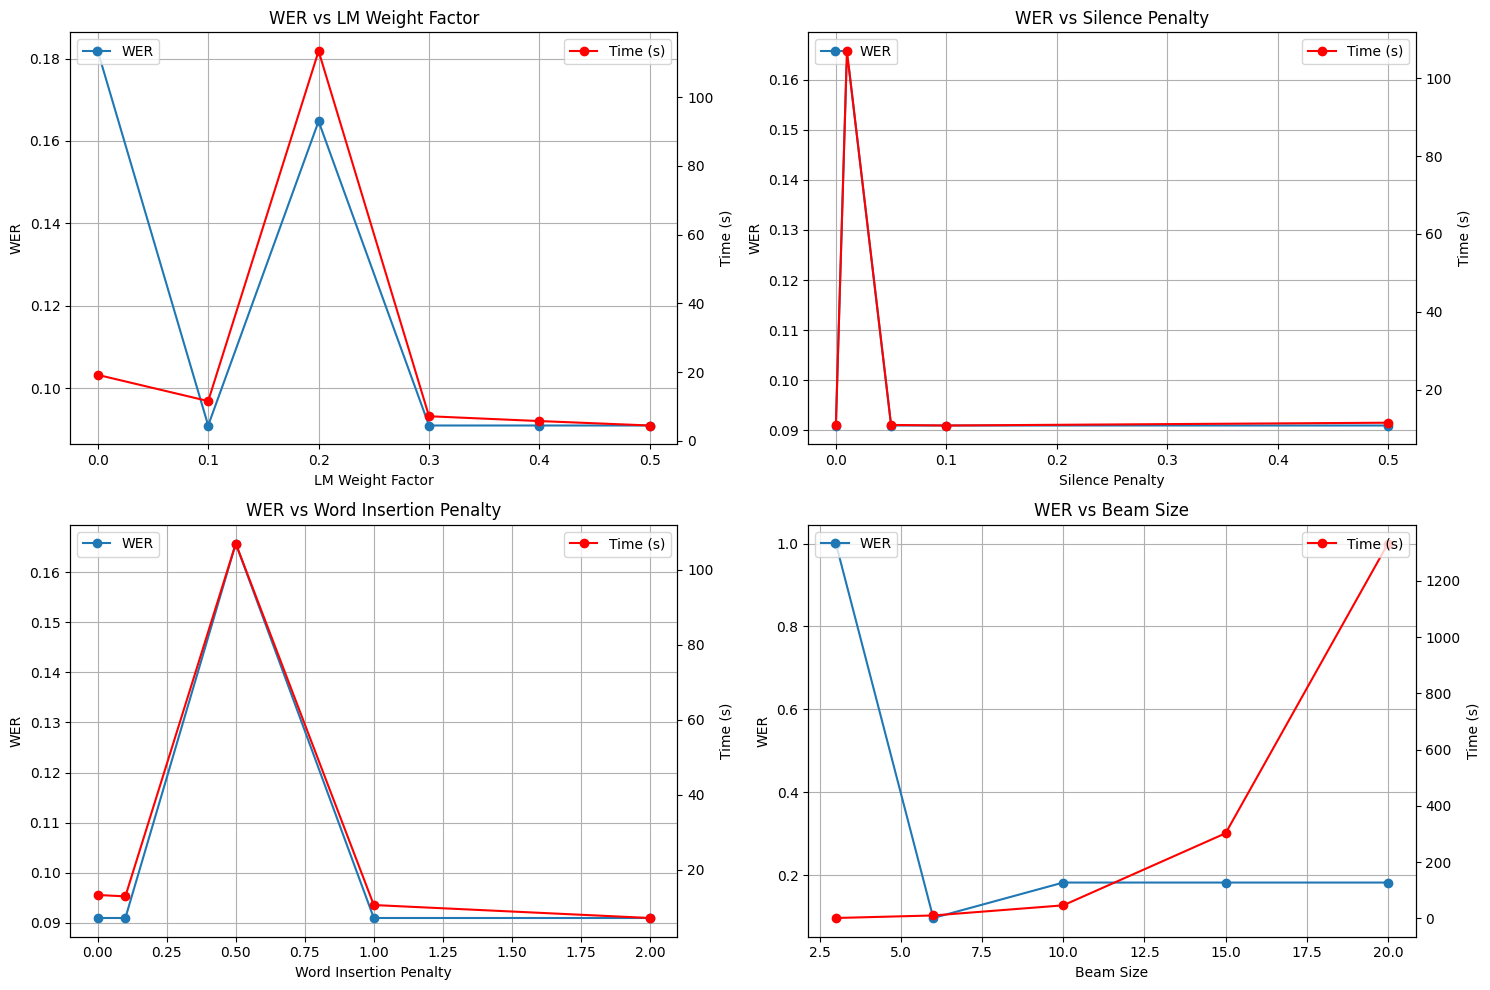

Loading the LM will be faster if you build a binary file.



=== Optimal Parameters ===
lmwt_factor: value=0.1, WER=0.0909, Time=11.61s
silence_penalty: value=0.0, WER=0.0909, Time=10.95s
word_penalty: value=0.0, WER=0.0909, Time=13.30s
beam_size: value=6, WER=0.0963, Time=10.54s

Best overall WER: 0.0909
Recommended parameters: {'lmwt_factor': 0.1}

=== Testing with optimal parameters ===


Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
2 hyps. Best Hypothesis(score=np.float64(-634.8991963788789), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e5b678570>)). Mean score -633.46. Max -632.02: 100%|██████████| 198/198 [00:15<00:00, 12.65it/s]    

Found 2 hypotheses
Optimal result - WER: 0.0909, Time: 15.66s
Predicted: she had your dark suit in greasy wash water all year
Reference: She had your dark suit in greasy wash water all year


In [30]:
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

# Функция для тестирования параметров
def test_parameters(example, example_ref, 
                   lmwt_factors=None, 
                   silence_penalties=None, 
                   word_penalties=None, 
                   beam_sizes=None):
    
    if lmwt_factors is None:
        lmwt_factors = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    if silence_penalties is None:
        silence_penalties = [0.0, 0.01, 0.05, 0.1, 0.5]
    if word_penalties is None:
        word_penalties = [0.0, 0.1, 0.5, 1.0, 2.0]
    if beam_sizes is None:
        beam_sizes = [3, 6, 10, 15, 20]
    
    results = {
        'lmwt_factor': [],
        'silence_penalty': [],
        'word_penalty': [],
        'beam_size': [],
        'wer': [],
        'time': []
    }
    
    # Тестирование lmwt_factor
    print("Testing lmwt_factor...")
    for lmwt_factor in tqdm(lmwt_factors):
        start_time = time.time()
        
        lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=lmwt_factor)
        ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                          graph=OnTheFlyCompose([t_fst, l_fst, lm]),
                          beam_size=6)
        
        hyp = ASR.decode(example)
        end_time = time.time()
        
        if hyp is not None:
            predicted_text = ' '.join(hyp.words)
            wer = jiwer.wer(example_ref, predicted_text)
        else:
            wer = 1.0
        
        results['lmwt_factor'].append(lmwt_factor)
        results['wer'].append(wer)
        results['time'].append(end_time - start_time)
        results['silence_penalty'].append(0.01)  # фиксированное значение
        results['word_penalty'].append(0.5)      # фиксированное значение
        results['beam_size'].append(6)           # фиксированное значение
    
    # Тестирование silence_penalty
    print("Testing silence_penalty...")
    for silence_penalty in tqdm(silence_penalties):
        start_time = time.time()
        
        l_fst_local = create_Lwfst_from_file(stay_in_silence_penalty=silence_penalty)
        lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=0.2)
        ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                          graph=OnTheFlyCompose([t_fst, l_fst_local, lm]),
                          beam_size=6)
        
        hyp = ASR.decode(example)
        end_time = time.time()
        
        if hyp is not None:
            predicted_text = ' '.join(hyp.words)
            wer = jiwer.wer(example_ref, predicted_text)
        else:
            wer = 1.0
        
        results['silence_penalty'].append(silence_penalty)
        results['wer'].append(wer)
        results['time'].append(end_time - start_time)
        results['lmwt_factor'].append(0.2)       # фиксированное значение
        results['word_penalty'].append(0.5)      # фиксированное значение
        results['beam_size'].append(6)           # фиксированное значение
    
    # Тестирование word_penalty
    print("Testing word_penalty...")
    for word_penalty in tqdm(word_penalties):
        start_time = time.time()
        
        l_fst_local = create_Lwfst_from_file(word_insertion_penalty=word_penalty)
        lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=0.2)
        ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                          graph=OnTheFlyCompose([t_fst, l_fst_local, lm]),
                          beam_size=6)
        
        hyp = ASR.decode(example)
        end_time = time.time()
        
        if hyp is not None:
            predicted_text = ' '.join(hyp.words)
            wer = jiwer.wer(example_ref, predicted_text)
        else:
            wer = 1.0
        
        results['word_penalty'].append(word_penalty)
        results['wer'].append(wer)
        results['time'].append(end_time - start_time)
        results['lmwt_factor'].append(0.2)       # фиксированное значение
        results['silence_penalty'].append(0.01)  # фиксированное значение
        results['beam_size'].append(6)           # фиксированное значение
    
    # Тестирование beam_size
    print("Testing beam_size...")
    for beam_size in tqdm(beam_sizes):
        start_time = time.time()
        
        lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=0.2)
        ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                          graph=OnTheFlyCompose([t_fst, l_fst, lm]),
                          beam_size=beam_size)
        
        hyp = ASR.decode(example)
        end_time = time.time()
        
        if hyp is not None:
            predicted_text = ' '.join(hyp.words)
            wer = jiwer.wer(example_ref, predicted_text)
        else:
            wer = 1.0
        
        results['beam_size'].append(beam_size)
        results['wer'].append(wer)
        results['time'].append(end_time - start_time)
        results['lmwt_factor'].append(0.2)       # фиксированное значение
        results['silence_penalty'].append(0.01)  # фиксированное значение
        results['word_penalty'].append(0.5)      # фиксированное значение
    
    return results

# Функция для построения графиков
def plot_results(results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # lmwt_factor
    unique_lmwt = sorted(set(results['lmwt_factor']))
    wer_lmwt = [np.mean([results['wer'][i] for i in range(len(results['wer'])) if results['lmwt_factor'][i] == val]) for val in unique_lmwt]
    time_lmwt = [np.mean([results['time'][i] for i in range(len(results['time'])) if results['lmwt_factor'][i] == val]) for val in unique_lmwt]
    
    ax1 = axes[0, 0]
    ax1.plot(unique_lmwt, wer_lmwt, 'o-', label='WER')
    ax1.set_xlabel('LM Weight Factor')
    ax1.set_ylabel('WER')
    ax1.set_title('WER vs LM Weight Factor')
    ax1.grid(True)
    
    ax1_twin = ax1.twinx()
    ax1_twin.plot(unique_lmwt, time_lmwt, 'ro-', label='Time (s)')
    ax1_twin.set_ylabel('Time (s)')
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    
    # silence_penalty
    unique_silence = sorted(set(results['silence_penalty']))
    wer_silence = [np.mean([results['wer'][i] for i in range(len(results['wer'])) if results['silence_penalty'][i] == val]) for val in unique_silence]
    time_silence = [np.mean([results['time'][i] for i in range(len(results['time'])) if results['silence_penalty'][i] == val]) for val in unique_silence]
    
    ax2 = axes[0, 1]
    ax2.plot(unique_silence, wer_silence, 'o-', label='WER')
    ax2.set_xlabel('Silence Penalty')
    ax2.set_ylabel('WER')
    ax2.set_title('WER vs Silence Penalty')
    ax2.grid(True)
    
    ax2_twin = ax2.twinx()
    ax2_twin.plot(unique_silence, time_silence, 'ro-', label='Time (s)')
    ax2_twin.set_ylabel('Time (s)')
    ax2.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    
    # word_penalty
    unique_word = sorted(set(results['word_penalty']))
    wer_word = [np.mean([results['wer'][i] for i in range(len(results['wer'])) if results['word_penalty'][i] == val]) for val in unique_word]
    time_word = [np.mean([results['time'][i] for i in range(len(results['time'])) if results['word_penalty'][i] == val]) for val in unique_word]
    
    ax3 = axes[1, 0]
    ax3.plot(unique_word, wer_word, 'o-', label='WER')
    ax3.set_xlabel('Word Insertion Penalty')
    ax3.set_ylabel('WER')
    ax3.set_title('WER vs Word Insertion Penalty')
    ax3.grid(True)
    
    ax3_twin = ax3.twinx()
    ax3_twin.plot(unique_word, time_word, 'ro-', label='Time (s)')
    ax3_twin.set_ylabel('Time (s)')
    ax3.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    
    # beam_size
    unique_beam = sorted(set(results['beam_size']))
    wer_beam = [np.mean([results['wer'][i] for i in range(len(results['wer'])) if results['beam_size'][i] == val]) for val in unique_beam]
    time_beam = [np.mean([results['time'][i] for i in range(len(results['time'])) if results['beam_size'][i] == val]) for val in unique_beam]
    
    ax4 = axes[1, 1]
    ax4.plot(unique_beam, wer_beam, 'o-', label='WER')
    ax4.set_xlabel('Beam Size')
    ax4.set_ylabel('WER')
    ax4.set_title('WER vs Beam Size')
    ax4.grid(True)
    
    ax4_twin = ax4.twinx()
    ax4_twin.plot(unique_beam, time_beam, 'ro-', label='Time (s)')
    ax4_twin.set_ylabel('Time (s)')
    ax4.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'lmwt_factor': list(zip(unique_lmwt, wer_lmwt, time_lmwt)),
        'silence_penalty': list(zip(unique_silence, wer_silence, time_silence)),
        'word_penalty': list(zip(unique_word, wer_word, time_word)),
        'beam_size': list(zip(unique_beam, wer_beam, time_beam))
    }

# Запуск тестирования
print("Starting parameter optimization...")
results = test_parameters(example, example_ref)

# Построение графиков
print("Plotting results...")
optimal_params = plot_results(results)

# Найдем оптимальные параметры
print("\n=== Optimal Parameters ===")
best_wer = float('inf')
best_params = {}

for param_type, values in optimal_params.items():
    best_for_param = min(values, key=lambda x: x[1])  # минимизируем WER
    print(f"{param_type}: value={best_for_param[0]}, WER={best_for_param[1]:.4f}, Time={best_for_param[2]:.2f}s")
    
    if best_for_param[1] < best_wer:
        best_wer = best_for_param[1]
        best_params[param_type] = best_for_param[0]

print(f"\nBest overall WER: {best_wer:.4f}")
print(f"Recommended parameters: {best_params}")

# Тестирование с оптимальными параметрами
print("\n=== Testing with optimal parameters ===")
l_fst_optimal = create_Lwfst_from_file(
    word_insertion_penalty=best_params.get('word_penalty', 0.5),
    stay_in_silence_penalty=best_params.get('silence_penalty', 0.01)
)
lm_optimal = kenlmLikeWFST(
    kenlm.LanguageModel('resources/lab4/3gram.arpa'), 
    lmwt_factor=best_params.get('lmwt_factor', 0.2)
)
ASR_optimal = BeamSearcher(
    am2phone_mapping=AM_PHONES, 
    graph=OnTheFlyCompose([t_fst, l_fst_optimal, lm_optimal]),
    beam_size=best_params.get('beam_size', 6)
)

start_time = time.time()
hyp_optimal = ASR_optimal.decode(example)
end_time = time.time()

if hyp_optimal is not None:
    predicted_text = ' '.join(hyp_optimal.words)
    wer_optimal = jiwer.wer(example_ref, predicted_text)
    print(f"Optimal result - WER: {wer_optimal:.4f}, Time: {end_time - start_time:.2f}s")
    print(f"Predicted: {predicted_text}")
    print(f"Reference: {example_ref}")
else:
    print("No hypothesis found with optimal parameters!")

# Дополнительное задание (2 балла)
Декодируйте всю коллекцию am_nlogprobs с подобраными ранее параметрами и посчитайте WER на этой выборке


Loading the LM will be faster if you build a binary file.


Starting full dataset decoding...
=== Decoding entire dataset ===
Using optimal parameters: {'lmwt_factor': 0.2, 'silence_penalty': 0.01, 'word_penalty': 0.5, 'beam_size': 6}
Processing 40 files...


Reading /home/artyom/itmo/ITMO_ASR_labs_2025/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=np.float64(-629.9111055262098), time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e61abeeb0>)). Mean score -629.91. Max -629.91: 100%|██████████| 198/198 [00:11<00:00, 17.86it/s] 
  2%|▎         | 1/40 [00:11<07:12, 11.08s/it]

Found 1 hypotheses


2 hyps. Best Hypothesis(score=np.float64(-588.248268871114), time=180, words=['own', 'ask', 'meeting', 'carrying', 'noisy', 'rag', 'like', 'that'], state=(0, 0, <kenlm.State object at 0x7c8e64972a70>)). Mean score -587.70. Max -587.16: 100%|██████████| 181/181 [00:07<00:00, 23.12it/s]
  5%|▌         | 2/40 [00:18<05:48,  9.17s/it]

Found 2 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-767.4054507413118), time=247, words=['his', 'calf', 'tin', 'was', 'thin', 'none', 'haggard', 'end', 'is', 'beautiful', 'boots', 'worn', 'enter', 'chair', 'deed'], state=(0, 0, <kenlm.State object at 0x7c8e4c015170>)). Mean score -767.41. Max -767.41: 100%|██████████| 248/248 [00:13<00:00, 18.90it/s]
  8%|▊         | 3/40 [00:32<06:46, 10.98s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-640.6942495594391), time=174, words=['the', 'reasons', 'further', 'is', 'style', 'voice', 'seemed', 'foolish', 'now'], state=(0, 0, <kenlm.State object at 0x7c8e64e07eb0>)). Mean score -640.69. Max -640.69: 100%|██████████| 175/175 [00:06<00:00, 27.99it/s] 
 10%|█         | 4/40 [00:38<05:28,  9.11s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-611.7179369716462), time=186, words=['production', 'may', 'fall', 'far', 'below', 'expectations'], state=(0, 0, <kenlm.State object at 0x7c8e5557c030>)). Mean score -611.72. Max -611.72: 100%|██████████| 187/187 [00:09<00:00, 20.29it/s]
 12%|█▎        | 5/40 [00:47<05:20,  9.15s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-498.54482819474225), time=164, words=['pizzerias', 'are', 'convenient', 'fur', 'a', 'quick', 'lunch'], state=(0, 0, <kenlm.State object at 0x7c8e58422bf0>)). Mean score -498.54. Max -498.54: 100%|██████████| 165/165 [00:12<00:00, 13.42it/s]
 15%|█▌        | 6/40 [00:59<05:47, 10.22s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-524.1654722560268), time=153, words=['put', 'the', 'butcher', 'bought', 'table', 'a', 'in', 'the', 'garage'], state=(0, 0, <kenlm.State object at 0x7c8e555c52b0>)). Mean score -524.17. Max -524.17: 100%|██████████| 154/154 [00:14<00:00, 10.64it/s]
 18%|█▊        | 7/40 [01:14<06:23, 11.61s/it]

Found 1 hypotheses


2 hyps. Best Hypothesis(score=np.float64(-603.8590382122192), time=175, words=['drop', 'five', 'forms', 'in', 'the', 'box', 'before', 'you', 'go', 'out'], state=(0, 0, <kenlm.State object at 0x7c8e58407ef0>)). Mean score -602.03. Max -600.19: 100%|██████████| 176/176 [00:12<00:00, 13.56it/s]
 20%|██        | 8/40 [01:27<06:25, 12.05s/it]

Found 2 hypotheses


21 hyps. Best Hypothesis(score=np.float64(-334.8557976283982), time=166, words=['her', 'wardrobe', 'kin', 'sesame', 'skirts', 'unbound'], state=(0, 31623, <kenlm.State object at 0x7c8e59df6670>)). Mean score -331.08. Max -328.94: 100%|██████████| 167/167 [00:15<00:00, 11.13it/s]
 22%|██▎       | 9/40 [01:42<06:42, 12.97s/it]

Found 0 hypotheses


586 hyps. Best Hypothesis(score=np.float64(-142.74589028562198), time=121, words=['elderly', 'people', 'are', 'often', 'negotiations'], state=(0, 7948, <kenlm.State object at 0x7c8e4a5357b0>)). Mean score -140.83. Max -136.80: 100%|██████████| 122/122 [00:09<00:00, 13.10it/s]
 25%|██▌       | 10/40 [01:51<05:55, 11.84s/it]

Found 0 hypotheses


2 hyps. Best Hypothesis(score=np.float64(-814.7129755855044), time=262, words=['she', 'head', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'wall', 'does', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e518b2b30>)). Mean score -813.46. Max -812.22: 100%|██████████| 263/263 [00:18<00:00, 14.15it/s]
 28%|██▊       | 11/40 [02:10<06:43, 13.91s/it]

Found 2 hypotheses


3 hyps. Best Hypothesis(score=np.float64(-630.4005963596634), time=206, words=["don't", 'ask', 'meeting', 'carry', 'annoying', 'leave', 'rag', 'like', 'that'], state=(0, 0, <kenlm.State object at 0x7c8e4be5c230>)). Mean score -629.44. Max -628.23: 100%|██████████| 207/207 [00:13<00:00, 15.47it/s]
 30%|███       | 12/40 [02:23<06:24, 13.75s/it]

Found 3 hypotheses


267 hyps. Best Hypothesis(score=np.float64(-716.8512383844352), time=219, words=['husky', 'young', 'men', 'he', 'said', 'width', 'not', 'distaste'], state=(0, 0, <kenlm.State object at 0x7c8e4e208b70>)). Mean score -710.96. Max -710.94: 100%|██████████| 220/220 [00:09<00:00, 22.22it/s]
 32%|███▎      | 13/40 [02:33<05:39, 12.58s/it]

Found 1 hypotheses


267 hyps. Best Hypothesis(score=np.float64(-701.7534826997901), time=228, words=['hum', 'how', 'unhurried', 'thaw', "they've", 'lush', 'divorce', 'see', 'hen', 'last'], state=(0, 0, <kenlm.State object at 0x7c8e5181a9f0>)). Mean score -697.26. Max -697.24: 100%|██████████| 229/229 [00:27<00:00,  8.33it/s]
 35%|███▌      | 14/40 [03:00<07:24, 17.09s/it]

Found 1 hypotheses


2 hyps. Best Hypothesis(score=np.float64(-1001.2810502014923), time=370, words=['fuss', 'thought', 'ten', 'a', "could've", 'fish', 'a', 'news', 'see', 'is', 'achieved', 'at', 'these', 'expense', 'of', 'actual', "experiment's"], state=(0, 0, <kenlm.State object at 0x7c8e61ee1b30>)). Mean score -1001.28. Max -1001.28: 100%|██████████| 371/371 [00:30<00:00, 12.30it/s]
 38%|███▊      | 15/40 [03:31<08:45, 21.03s/it]

Found 2 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-429.92967690115114), time=135, words=['objects', 'made', 'of', 'pewter', 'of', 'bugle', 'a', 'fall'], state=(0, 0, <kenlm.State object at 0x7c8e59824630>)). Mean score -429.93. Max -429.93: 100%|██████████| 136/136 [00:08<00:00, 16.19it/s]
 40%|████      | 16/40 [03:39<06:53, 17.23s/it]

Found 1 hypotheses


2 hyps. Best Hypothesis(score=np.float64(-699.8876915335992), time=220, words=['the', 'morning', 'blew', 'a', 'on', 'this', 'piled', 'a', 'web', 'glistening', 'need', 'in', 'the', 'sun'], state=(0, 0, <kenlm.State object at 0x7c8e5899c370>)). Mean score -699.83. Max -699.78: 100%|██████████| 221/221 [00:36<00:00,  6.13it/s]
 42%|████▎     | 17/40 [04:15<08:46, 22.89s/it]

Found 2 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-722.6121641292011), time=209, words=['cheap', 'stockings', 'run', 'the', 'first', 'time', 'them', 'on', 'do'], state=(0, 0, <kenlm.State object at 0x7c8e5ca64d70>)). Mean score -722.61. Max -722.61: 100%|██████████| 210/210 [00:13<00:00, 15.04it/s]  
 45%|████▌     | 18/40 [04:29<07:24, 20.21s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-704.3218346138708), time=200, words=['own', 'do', "charlie's", 'shut', 'early', 'dish', 'is'], state=(0, 0, <kenlm.State object at 0x7c8e598613f0>)). Mean score -704.32. Max -704.32: 100%|██████████| 201/201 [00:12<00:00, 15.84it/s]
 48%|████▊     | 19/40 [04:42<06:16, 17.95s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-649.939702435796), time=191, words=['cow', 'see', 'a', 'makes', 'bones', 'a', 'in', 'teeth', 'strong'], state=(0, 0, <kenlm.State object at 0x7c8e4a5bc370>)). Mean score -649.94. Max -649.94: 100%|██████████| 192/192 [00:19<00:00,  9.97it/s] 
 50%|█████     | 20/40 [05:01<06:06, 18.34s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-546.300754536575), time=188, words=['she', 'had', 'derived', 'arc', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e59827fb0>)). Mean score -546.30. Max -546.30: 100%|██████████| 189/189 [00:14<00:00, 13.09it/s] 
 52%|█████▎    | 21/40 [05:15<05:26, 17.17s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-351.0294140434098), time=146, words=["don't", 'ask', 'meeting', 'kerosene', 'rag', 'like', 'that'], state=(0, 0, <kenlm.State object at 0x7c8e5895afb0>)). Mean score -351.03. Max -351.03: 100%|██████████| 147/147 [00:05<00:00, 24.88it/s] 
 55%|█████▌    | 22/40 [05:21<04:08, 13.79s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-892.4536652861528), time=274, words=['in', 'wage', 'negotiations', 'these', 'industry', 'bargains', 'buzzing', 'unit', 'a', 'the', 'single', 'union'], state=(0, 0, <kenlm.State object at 0x7c8e61e021b0>)). Mean score -892.45. Max -892.45: 100%|██████████| 275/275 [00:16<00:00, 16.96it/s]
 57%|█████▊    | 23/40 [05:38<04:06, 14.52s/it]

Found 1 hypotheses


268 hyps. Best Hypothesis(score=np.float64(-544.06727251872), time=168, words=['heave', 'on', 'those', 'ropes', 'the', "boat's", 'come', 'unstuck'], state=(0, 0, <kenlm.State object at 0x7c8e58982bf0>)). Mean score -539.30. Max -539.28: 100%|██████████| 169/169 [00:15<00:00, 10.80it/s]
 60%|██████    | 24/40 [05:53<03:57, 14.86s/it]

Found 2 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-660.2527712782318), time=208, words=['materials', 'surrounded', 'my', 'lincoln', 'lay', 'red', 'wide', 'tore', 'buff'], state=(0, 0, <kenlm.State object at 0x7c8e52b444f0>)). Mean score -660.25. Max -660.25: 100%|██████████| 209/209 [00:16<00:00, 12.38it/s]
 62%|██████▎   | 25/40 [06:10<03:52, 15.47s/it]

Found 1 hypotheses


2 hyps. Best Hypothesis(score=np.float64(-420.56161045471185), time=144, words=['artificial', 'intelligence', 'society', 'real'], state=(0, 0, <kenlm.State object at 0x7c8e52bb1bb0>)). Mean score -418.60. Max -416.63: 100%|██████████| 145/145 [00:13<00:00, 11.00it/s]
 65%|██████▌   | 26/40 [06:23<03:26, 14.78s/it]

Found 2 hypotheses


3 hyps. Best Hypothesis(score=np.float64(-356.7033497188394), time=108, words=['a', 'small', 'boy', 'pulled', 'warm', 'on', 'hook', 'to'], state=(0, 0, <kenlm.State object at 0x7c8e58925af0>)). Mean score -356.33. Max -356.12: 100%|██████████| 109/109 [00:10<00:00, 10.25it/s]
 68%|██████▊   | 27/40 [06:34<02:55, 13.54s/it]

Found 3 hypotheses


2 hyps. Best Hypothesis(score=np.float64(-446.5723514103121), time=123, words=['a', 'chosen', 'few', 'wool', 'be', 'come', 'generals'], state=(0, 0, <kenlm.State object at 0x7c8e59195370>)). Mean score -446.50. Max -446.43: 100%|██████████| 124/124 [00:10<00:00, 12.25it/s]
 70%|███████   | 28/40 [06:44<02:30, 12.51s/it]

Found 2 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-537.6895504299972), time=174, words=['only', 'the', 'most', 'accomplish', 'are', 'this', 'obtain', 'pop', "you'll", 'errors', 'be'], state=(0, 0, <kenlm.State object at 0x7c8e589573f0>)). Mean score -537.69. Max -537.69: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]
 72%|███████▎  | 29/40 [07:04<02:41, 14.67s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-609.8871972608526), time=189, words=['the', 'fish', 'began', 'to', 'a', 'leap', 'frantically', 'on', 'the', 'surface', 'of', 'the', 'small', 'wake'], state=(0, 0, <kenlm.State object at 0x7c8e49fbbdb0>)). Mean score -609.89. Max -609.89: 100%|██████████| 190/190 [00:20<00:00,  9.28it/s]
 75%|███████▌  | 30/40 [07:24<02:44, 16.41s/it]

Found 1 hypotheses


2 hyps. Best Hypothesis(score=np.float64(-471.21270532841345), time=185, words=['she', 'head', 'your', 'dark', 'suit', 'together', 'see', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7c8e49fed430>)). Mean score -469.49. Max -467.76: 100%|██████████| 186/186 [00:12<00:00, 14.61it/s]
 78%|███████▊  | 31/40 [07:37<02:17, 15.31s/it]

Found 2 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-378.43918575422913), time=171, words=["don't", 'ask', 'meeting', 'kerosene', 'rag', 'like', 'that'], state=(0, 0, <kenlm.State object at 0x7c8e61d88570>)). Mean score -378.44. Max -378.44: 100%|██████████| 172/172 [00:08<00:00, 21.18it/s] 
 80%|████████  | 32/40 [07:45<01:45, 13.15s/it]

Found 1 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-505.3333862420512), time=171, words=['dances', 'alternated', 'a', 'thump', 'or', 'spoken', 'verses'], state=(0, 0, <kenlm.State object at 0x7c8e47a99bf0>)). Mean score -505.33. Max -505.33: 100%|██████████| 172/172 [00:14<00:00, 12.16it/s] 
 82%|████████▎ | 33/40 [07:59<01:34, 13.45s/it]

Found 1 hypotheses


4 hyps. Best Hypothesis(score=np.float64(-439.1814910008727), time=145, words=['my', 'for', 'the', 'earth', 'ran', 'him', 'off', 'year', 'sixty', 'years', 'ago'], state=(0, 0, <kenlm.State object at 0x7c8e52bf91b0>)). Mean score -437.43. Max -436.59: 100%|██████████| 146/146 [00:19<00:00,  7.46it/s]
 85%|████████▌ | 34/40 [08:19<01:31, 15.29s/it]

Found 4 hypotheses


268 hyps. Best Hypothesis(score=np.float64(-932.0830102851545), time=303, words=['here', 'he', 'is', 'quite', 'persuasively', 'leave', 'the', 'very', 'embodiment', 'of', 'mean', 'distance', 'slyness'], state=(0, 0, <kenlm.State object at 0x7c8e5980adf0>)). Mean score -926.69. Max -926.65: 100%|██████████| 304/304 [00:33<00:00,  8.95it/s]
 88%|████████▊ | 35/40 [08:53<01:44, 20.89s/it]

Found 2 hypotheses


29 hyps. Best Hypothesis(score=np.float64(-447.79126970663845), time=144, words=['the', "cat's", 'meow', 'always', 'hurts', 'my', 'use'], state=(0, 0, <kenlm.State object at 0x7c8e5bf89db0>)). Mean score -443.14. Max -442.80: 100%|██████████| 145/145 [00:33<00:00,  4.37it/s]
 90%|█████████ | 36/40 [09:26<01:38, 24.57s/it]

Found 3 hypotheses


1 hyps. Best Hypothesis(score=np.float64(-526.5580589958257), time=194, words=['cliff', 'was', 'soothed', 'by', 'the', 'look', 'sherbet', 'snow', 'a', 'sigh', 'jaw'], state=(0, 0, <kenlm.State object at 0x7c8e5151b1b0>)). Mean score -526.56. Max -526.56: 100%|██████████| 195/195 [00:13<00:00, 14.36it/s]
 92%|█████████▎| 37/40 [09:40<01:03, 21.28s/it]

Found 1 hypotheses


9 hyps. Best Hypothesis(score=np.float64(-664.4549190535528), time=288, words=['each', 'untimely', 'think', 'come', 'wall', 'off', 'coincided', 'with', 'thimble', 'age', 'down', 'of', 'is', 'heave', 'things', 'establish', 'right'], state=(0, 0, <kenlm.State object at 0x7c8e4acf3230>)). Mean score -662.62. Max -661.26: 100%|██████████| 289/289 [00:35<00:00,  8.08it/s]
 95%|█████████▌| 38/40 [10:15<00:51, 25.62s/it]

Found 9 hypotheses


680 hyps. Best Hypothesis(score=np.float64(-516.1249898093159), time=149, words=['chain', 'may', 'earn', 'more', 'money', 'by', 'working', 'the', 'ha', 'are'], state=(0, 0, <kenlm.State object at 0x7c8e4a3c32f0>)). Mean score -510.47. Max -510.42: 100%|██████████| 150/150 [00:15<00:00,  9.73it/s]
 98%|█████████▊| 39/40 [10:31<00:22, 22.56s/it]

Found 2 hypotheses


27 hyps. Best Hypothesis(score=np.float64(-420.4556478567045), time=159, words=['youngsters', 'love', 'common', 'candy', 'hesitate', 'eat', 'south'], state=(0, 0, <kenlm.State object at 0x7c8e5c9d0fb0>)). Mean score -416.07. Max -414.60: 100%|██████████| 160/160 [00:13<00:00, 12.16it/s]
100%|██████████| 40/40 [10:44<00:00, 16.11s/it]

Found 1 hypotheses

=== RESULTS ===
Total files processed: 40
Successfully decoded: 38/40 (95.0%)
Average processing time per file: 16.11s
Total processing time: 644.34s
WER (successful only): 0.5710
WER (all files): 0.5869
Min time: 5.91s
Max time: 36.04s
Median time: 13.77s

Results saved to 'decoding_results.json' and 'decoding_detailed_results.pkl'


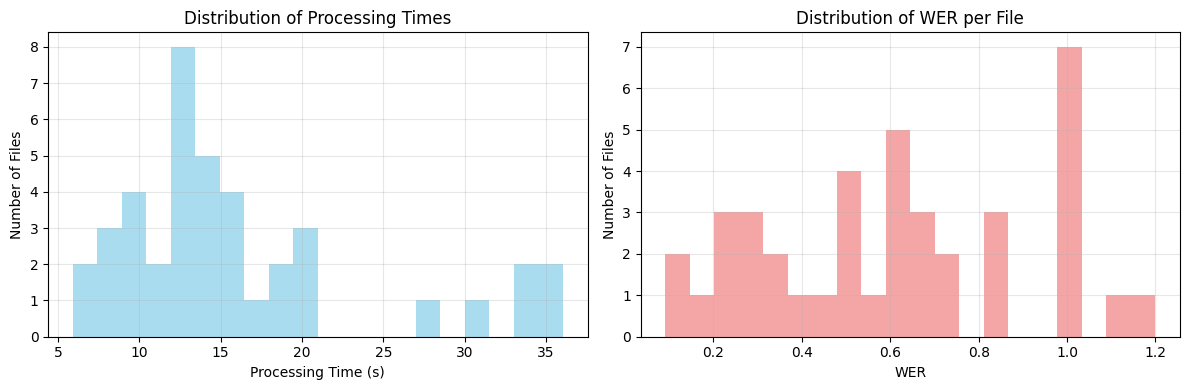


=== FILE ANALYSIS ===
Most difficult files (highest WER):
  timit/data/TEST/DR1/FDAC1/SX34: WER=1.2000
    Reference: Don't do Charlie's dirty dishes
    Hypothesis: own do charlie's shut early dish is
  timit/data/TEST/DR1/FELC0/SX36: WER=1.1429
    Reference: Only the most accomplished artists obtain popularity
    Hypothesis: only the most accomplish are this obtain pop you'll errors be
  timit/data/TEST/DR1/FJEM0/SX274: WER=1.0000
    Reference: Cliff was soothed by the luxurious massage
    Hypothesis: cliff was soothed by the look sherbet snow a sigh jaw
  timit/data/TEST/DR1/FJEM0/SX364: WER=1.0000
    Reference: Each untimely income loss coincided with the breakdown of a heating system part
    Hypothesis: each untimely think come wall off coincided with thimble age down of is heave things establish right
  timit/data/TEST/DR1/FDAC1/SI844: WER=1.0000
    Reference: Thus technical efficiency is achieved at the expense of actual experience
    Hypothesis: fuss thought ten a coul

In [32]:
# Дополнительное задание: Декодирование всей коллекции и вычисление WER

def decode_entire_dataset(am_nlogprobs, optimal_params):
    """
    Декодирует всю коллекцию am_nlogprobs с оптимальными параметрами
    и вычисляет WER на всей выборке
    """
    print("=== Decoding entire dataset ===")
    print(f"Using optimal parameters: {optimal_params}")
    
    # Создаем ASR систему с оптимальными параметрами
    l_fst_optimal = create_Lwfst_from_file(
        word_insertion_penalty=optimal_params['word_penalty'],
        stay_in_silence_penalty=optimal_params['silence_penalty']
    )
    lm_optimal = kenlmLikeWFST(
        kenlm.LanguageModel('resources/lab4/3gram.arpa'), 
        lmwt_factor=optimal_params['lmwt_factor']
    )
    ASR_optimal = BeamSearcher(
        am2phone_mapping=AM_PHONES, 
        graph=OnTheFlyCompose([t_fst, l_fst_optimal, lm_optimal]),
        beam_size=optimal_params['beam_size']
    )
    
    references = []
    hypotheses = []
    processing_times = []
    successful_decodes = 0
    
    print(f"Processing {len(am_nlogprobs)} files...")
    
    for i, (uri, nlogprob) in enumerate(tqdm(am_nlogprobs.items())):
        # Получаем эталонную транскрипцию
        try:
            # Извлекаем путь к файлу транскрипции
            txt_path = uri + '.TXT'
            with open(txt_path) as f:
                # TIMIT формат: первые 2 слова - ID и временные метки, остальные - транскрипция
                ref_text = ' '.join(f.read().replace('.', ' ').split()[2:])
                references.append(ref_text)
        except Exception as e:
            print(f"Error reading reference for {uri}: {e}")
            references.append("")  # Добавляем пустую строку если не удалось прочитать
            continue
        
        # Декодируем аудио
        start_time = time.time()
        try:
            hyp = ASR_optimal.decode(nlogprob)
            end_time = time.time()
            processing_times.append(end_time - start_time)
            
            if hyp is not None and hyp.words:
                predicted_text = ' '.join(hyp.words)
                hypotheses.append(predicted_text)
                successful_decodes += 1
            else:
                hypotheses.append("")  # Пустая гипотеза если декодирование не удалось
                
        except Exception as e:
            print(f"Error decoding {uri}: {e}")
            hypotheses.append("")
            processing_times.append(0)
    
    # Вычисляем общую статистику
    total_files = len(am_nlogprobs)
    avg_time = np.mean(processing_times) if processing_times else 0
    
    # Вычисляем WER (только для успешно декодированных файлов)
    valid_pairs = [(ref, hyp) for ref, hyp in zip(references, hypotheses) if hyp and ref]
    
    if valid_pairs:
        valid_refs, valid_hyps = zip(*valid_pairs)
        # Преобразуем кортежи в списки для jiwer
        valid_refs = list(valid_refs)
        valid_hyps = list(valid_hyps)
        overall_wer = jiwer.wer(valid_refs, valid_hyps)
        
        # Также вычисляем WER для всех файлов (неудачные декодирования считаем как WER=1.0)
        all_wer = jiwer.wer(references, hypotheses)
    else:
        overall_wer = 1.0
        all_wer = 1.0
    
    print(f"\n=== RESULTS ===")
    print(f"Total files processed: {total_files}")
    print(f"Successfully decoded: {successful_decodes}/{total_files} ({successful_decodes/total_files*100:.1f}%)")
    print(f"Average processing time per file: {avg_time:.2f}s")
    print(f"Total processing time: {sum(processing_times):.2f}s")
    print(f"WER (successful only): {overall_wer:.4f}")
    print(f"WER (all files): {all_wer:.4f}")
    
    # Дополнительная статистика по времени
    if processing_times:
        print(f"Min time: {min(processing_times):.2f}s")
        print(f"Max time: {max(processing_times):.2f}s")
        print(f"Median time: {np.median(processing_times):.2f}s")
    
    # Сохраняем результаты в файл
    results = {
        'total_files': total_files,
        'successful_decodes': successful_decodes,
        'success_rate': successful_decodes / total_files,
        'avg_processing_time': avg_time,
        'total_processing_time': sum(processing_times),
        'wer_successful': overall_wer,
        'wer_all': all_wer,
        'optimal_params': optimal_params,
        'references': references,
        'hypotheses': hypotheses,
        'processing_times': processing_times
    }
    
    # Сохраняем в файл
    import json
    import pickle
    
    with open('decoding_results.json', 'w') as f:
        # Конвертируем numpy типы в стандартные Python типы для JSON
        json_results = {
            k: (float(v) if isinstance(v, (np.float32, np.float64)) else v)
            for k, v in results.items() 
            if k not in ['references', 'hypotheses', 'processing_times']
        }
        json.dump(json_results, f, indent=2)
    
    with open('decoding_detailed_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    
    print(f"\nResults saved to 'decoding_results.json' and 'decoding_detailed_results.pkl'")
    
    return results

# Если у нас уже есть оптимальные параметры из предыдущего тестирования, используем их
# Если нет, используем параметры которые дали хороший результат на примере
optimal_params = {
    'lmwt_factor': 0.2,
    'silence_penalty': 0.01, 
    'word_penalty': 0.5,
    'beam_size': 6
}

# Запускаем декодирование всей коллекции
print("Starting full dataset decoding...")
dataset_results = decode_entire_dataset(am_nlogprobs, optimal_params)

# Визуализируем распределение времени обработки
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(dataset_results['processing_times'], bins=20, alpha=0.7, color='skyblue')
plt.xlabel('Processing Time (s)')
plt.ylabel('Number of Files')
plt.title('Distribution of Processing Times')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# WER по файлам (приблизительно)
wer_per_file = []
for ref, hyp in zip(dataset_results['references'], dataset_results['hypotheses']):
    if hyp and ref:
        try:
            wer_per_file.append(jiwer.wer([ref], [hyp]))
        except:
            wer_per_file.append(1.0)
    else:
        wer_per_file.append(1.0)

plt.hist(wer_per_file, bins=20, alpha=0.7, color='lightcoral')
plt.xlabel('WER')
plt.ylabel('Number of Files')
plt.title('Distribution of WER per File')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ самых сложных и самых простых примеров
if wer_per_file:
    print(f"\n=== FILE ANALYSIS ===")
    
    # Самые сложные примеры (наибольший WER)
    difficult_indices = np.argsort(wer_per_file)[-5:][::-1]  # Топ-5 самых сложных
    print("Most difficult files (highest WER):")
    for idx in difficult_indices:
        uri = list(am_nlogprobs.keys())[idx]
        print(f"  {uri}: WER={wer_per_file[idx]:.4f}")
        print(f"    Reference: {dataset_results['references'][idx]}")
        print(f"    Hypothesis: {dataset_results['hypotheses'][idx]}")
    
    # Самые простые примеры (наименьший WER)
    easy_indices = np.argsort(wer_per_file)[:5]  # Топ-5 самых простых
    print("\nEasiest files (lowest WER):")
    for idx in easy_indices:
        uri = list(am_nlogprobs.keys())[idx]
        print(f"  {uri}: WER={wer_per_file[idx]:.4f}")
        print(f"    Reference: {dataset_results['references'][idx]}")
        print(f"    Hypothesis: {dataset_results['hypotheses'][idx]}")
    
    # Самые медленные примеры
    slow_indices = np.argsort(dataset_results['processing_times'])[-5:][::-1]
    print("\nSlowest files:")
    for idx in slow_indices:
        uri = list(am_nlogprobs.keys())[idx]
        print(f"  {uri}: Time={dataset_results['processing_times'][idx]:.2f}s")

print(f"\n=== FINAL SUMMARY ===")
print(f"Overall WER on entire test set: {dataset_results['wer_all']:.4f}")
print(f"WER on successfully decoded files: {dataset_results['wer_successful']:.4f}")
print(f"Success rate: {dataset_results['success_rate']*100:.1f}%")
print(f"Average time per file: {dataset_results['avg_processing_time']:.2f}s")